<h1><center>Investigation of loan data from Prosper</center></h1>

### Investigation Overview

In this project I want to explore the characteristics of loans from the peer-to-peer loan marketplace [Prosper](https://www.prosper.com/). The Investigation will we centered around four questions: 

- What causes people to take loans in the first place?
- What determines a borrowers apr (average percentage rate (interest rate + fees))?
- What affects the probabilities for different outcomes?
- Did the average apr change over time?

**This notebook** covers the **data wrangling process** and an **exploratory investigation** of the dataset. If you are just interested in a polished explanatory analysis, then please refer to the presentation.slides.html document.

### Dataset Overview

The dataset contains information for 105.000 transactions across 20 columns. Around 8.000 rows and 60 columns were removed from the original dataset for quality and tidiness purposes.

### The most important variables for this project include

- id: a unique key for every transaction
- date: the date the listing was created
- status: the status of the loan/outcome if applicable
- loan_amount: the loan amount borrowed
- credit_rating: Prosper's credit score with 1 being the worst and 7 the best
- borrower_apr: the annual percentage rate of the borrower
- lender_yield: the interest rate you receive as a lender minus servicing fees
- bank_yield: the difference between lender_yield and borrower_apr -> Prospers share in every deal
- income_range: yearly income of borrower
- monthly_income: monthly income of borrower
- income_verifiable: True if the borrower has documents to proof his stated monthly income
- homeowner: True if borrower already owns a home, False if not
- occupation: occupation of borrower, 21 categories
- employment_status: borrowers type of employment
- employment_status_duration: specifies how long the borrower is already employed (if applicable)
- homestate: state the borrower lives in
- reason: reason specified by borrower why he needs a loan
- credit_utilization: percentage of available revolving credit that is utilized by the borrower
- number_delinquencies: number of borrowers delinquencies in the last 7 years.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('prosperLoanData.csv')

## Assessing and Cleaning

In [3]:
df_clean = df.copy()

In [4]:
df_clean.head(2)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


#### Define

The DataFrame in its current form contains 81 rows, many of which contain data I'm not particularly interested in for this project. I'll therefore only keep 20 columns, and give them more appropriate names them.

#### Code

In [5]:
# define columns I want to keep
df_clean = df_clean[['ListingNumber', 'ListingCreationDate', 'LoanOriginalAmount', 'LoanStatus', 'CreditGrade', 'ProsperRating (numeric)',\
         'BorrowerAPR', 'LenderYield', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'MonthlyLoanPayment',\
         'DebtToIncomeRatio', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',\
         'BorrowerState', 'ListingCategory (numeric)', 'BankcardUtilization', 'DelinquenciesLast7Years']]

In [6]:
# rename columns
df_clean.columns = ['id', 'date', 'loan_amount', 'status', 'credit_grade', 'prosper_score', 'borrower_apr',\
                    'lender_yield', 'income_range', 'monthly_income', 'income_verifiable', 'monthly_loan_payment',\
                    'debt_ratio', 'homeowner', 'occupation', 'employment_status', 'employment_status_duration',\
                    'homestate', 'reason', 'credit_utilization', 'number_delinquencies']

#### Test

In [7]:
df_clean.head(2)

,id,date,loan_amount,status,credit_grade,prosper_score,borrower_apr,lender_yield,income_range,monthly_income,...,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate,reason,credit_utilization,number_delinquencies
0,193129,2007-08-26 19:09:29.263000000,9425,Completed,C,NaN,0.16516,0.138,"$25,000-49,999",3083.333333,...,330.43,0.17,True,Other,Self-employed,2.0,CO,0,0.00,4.0
1,1209647,2014-02-27 08:28:07.900000000,10000,Current,NaN,6.0,0.12016,0.082,"$50,000-74,999",6125.000000,...,318.93,0.18,False,Professional,Employed,44.0,CO,2,0.21,0.0


#### Define

The column ``credit_grade`` contains prospers credit ratings prior to 2009, the column ``prosper_score`` contains credit ratings applicable to loans after 2009. I want to combine both columns into one column containing the credit rating for both periods. The alphanumerical rating of the ``credit_grade`` grade column can be encoded as follows: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA. 

#### Code

In [8]:
# encode credit_grade column
df_clean.credit_grade = df_clean.credit_grade.map({'HR': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6, 'AA': 7})

# replace all NaN values with 0 so both columns can be added
df_clean[['credit_grade', 'prosper_score']] = df_clean[['credit_grade', 'prosper_score']].fillna(0)

# create new column credit_rating which is the sum of credit_grade and prosper_score.
df_clean['credit_rating'] = df_clean.credit_grade + df_clean.prosper_score
# drop old columns
df_clean.drop(columns = ['credit_grade', 'prosper_score'], axis = 1, inplace = True)

#### Test

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 20 columns):
id                            113937 non-null int64
date                          113937 non-null object
loan_amount                   113937 non-null int64
status                        113937 non-null object
borrower_apr                  113912 non-null float64
lender_yield                  113937 non-null float64
income_range                  113937 non-null object
monthly_income                113937 non-null float64
income_verifiable             113937 non-null bool
monthly_loan_payment          113937 non-null float64
debt_ratio                    105383 non-null float64
homeowner                     113937 non-null bool
occupation                    110349 non-null object
employment_status             111682 non-null object
employment_status_duration    106312 non-null float64
homestate                     108422 non-null object
reason                        113937 non-

#### Define

The column ``reason`` is also numerically encoded. I want to use the actual label here as it improves comprehensibility in my opinion.

#### Code

In [10]:
reason_encoding = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 4: 'Personal Loan',\
       5: 'Student Loan', 6: 'Car', 7: 'Other', 8: 'Baby/Adoption', 9: 'Boat', 10: 'Cosmetic Procedure',\
       11: 'Engagement Ring', 12: 'Green Loans', 13: 'Household Expenses', 14: 'Large Purchases',\
       15: 'Medical/Dental', 16: 'Motorcycle', 17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding Loans'}

df_clean.reason = df_clean.reason.map(reason_encoding)

#### Test

In [11]:
df_clean.reason.sample(2)

25874    Debt Consolidation
43590    Debt Consolidation
Name: reason, dtype: object

#### Define

There are rows which contain no value for the borrower_apr (average percentage rate). As this is one key metric, I'm going to drop all rows which contain NaN for borrower_apr.

#### Code

In [12]:
df_clean.dropna(subset = ['borrower_apr'], inplace = True)

#### Test

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113912 entries, 0 to 113936
Data columns (total 20 columns):
id                            113912 non-null int64
date                          113912 non-null object
loan_amount                   113912 non-null int64
status                        113912 non-null object
borrower_apr                  113912 non-null float64
lender_yield                  113912 non-null float64
income_range                  113912 non-null object
monthly_income                113912 non-null float64
income_verifiable             113912 non-null bool
monthly_loan_payment          113912 non-null float64
debt_ratio                    105358 non-null float64
homeowner                     113912 non-null bool
occupation                    110349 non-null object
employment_status             111682 non-null object
employment_status_duration    106312 non-null float64
homestate                     108422 non-null object
reason                        113912 non-

#### Define

I want to introduce one more column ``bank_yield``. The bank yield is the difference between the borrowers APR and the lenders yield (the lenders return for on investment) and thus provides information about prospers share on each deal. 

Then, reorder the columns so the rating and bank_yield are not at the very end.

#### Code

In [14]:
df_clean['bank_yield'] = df_clean['borrower_apr'] - df_clean['lender_yield']

In [15]:
cols = df_clean.columns.tolist()
cols

['id',
 'date',
 'loan_amount',
 'status',
 'borrower_apr',
 'lender_yield',
 'income_range',
 'monthly_income',
 'income_verifiable',
 'monthly_loan_payment',
 'debt_ratio',
 'homeowner',
 'occupation',
 'employment_status',
 'employment_status_duration',
 'homestate',
 'reason',
 'credit_utilization',
 'number_delinquencies',
 'credit_rating',
 'bank_yield']

In [16]:
cols = ['id', 'date', 'status', 'loan_amount', 'credit_rating', 'borrower_apr', 'lender_yield', 'bank_yield',\
        'income_range','monthly_income', 'income_verifiable', 'monthly_loan_payment', 'debt_ratio', 'homeowner',\
        'occupation', 'employment_status', 'employment_status_duration', 'homestate', 'reason', 'credit_utilization',\
        'number_delinquencies']

df_clean = df_clean[cols]

#### Test

In [17]:
df_clean.head(2)

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,...,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate,reason,credit_utilization,number_delinquencies
0,193129,2007-08-26 19:09:29.263000000,Completed,9425,4.0,0.16516,0.138,0.02716,"$25,000-49,999",3083.333333,...,330.43,0.17,True,Other,Self-employed,2.0,CO,Not Available,0.00,4.0
1,1209647,2014-02-27 08:28:07.900000000,Current,10000,6.0,0.12016,0.082,0.03816,"$50,000-74,999",6125.000000,...,318.93,0.18,False,Professional,Employed,44.0,CO,Home Improvement,0.21,0.0


#### Define

There are 8669 occasions where the borrower can not verify the stated monthly income. As this makes it impossible to assess whether those values are indeed valid or not, I'm going to drop those rows.

In [18]:
df_clean.income_verifiable.value_counts()

True     105243
False      8669
Name: income_verifiable, dtype: int64

#### Code

In [19]:
df_clean = df_clean[df_clean['income_verifiable'] == True]

#### Test

In [20]:
df_clean.income_verifiable.unique()

array([ True])

#### Define

- Change dtype of ``id`` to str
- Change dtype of ``date`` to datetime
- Change dtype of ``monthly_income`` to int (I'm fine with rounding here)
- Change dtype of ``monthly_loan_payment`` to int (I'm fine with rounding here)

#### Code

In [21]:
df_clean.id = df_clean.id.astype(str)
df_clean.date = pd.to_datetime(df_clean.date, yearfirst = True).dt.normalize()
df_clean.monthly_income = df_clean.monthly_income.astype(int)
df_clean.monthly_loan_payment = df_clean.monthly_loan_payment.astype(int)

#### Test

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105243 entries, 0 to 113936
Data columns (total 21 columns):
id                            105243 non-null object
date                          105243 non-null datetime64[ns]
status                        105243 non-null object
loan_amount                   105243 non-null int64
credit_rating                 105243 non-null float64
borrower_apr                  105243 non-null float64
lender_yield                  105243 non-null float64
bank_yield                    105243 non-null float64
income_range                  105243 non-null object
monthly_income                105243 non-null int32
income_verifiable             105243 non-null bool
monthly_loan_payment          105243 non-null int32
debt_ratio                    105078 non-null float64
homeowner                     105243 non-null bool
occupation                    101719 non-null object
employment_status             103052 non-null object
employment_status_duration    97764

In [23]:
df_clean.head()

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,...,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate,reason,credit_utilization,number_delinquencies
0,193129,2007-08-26,Completed,9425,4.0,0.16516,0.1380,0.02716,"$25,000-49,999",3083,...,330,0.17,True,Other,Self-employed,2.0,CO,Not Available,0.00,4.0
1,1209647,2014-02-27,Current,10000,6.0,0.12016,0.0820,0.03816,"$50,000-74,999",6125,...,318,0.18,False,Professional,Employed,44.0,CO,Home Improvement,0.21,0.0
2,81716,2007-01-05,Completed,3001,1.0,0.28269,0.2400,0.04269,Not displayed,2083,...,123,0.06,False,Other,Not available,NaN,GA,Not Available,NaN,0.0
3,658116,2012-10-22,Current,10000,6.0,0.12528,0.0874,0.03788,"$25,000-49,999",2875,...,321,0.15,True,Skilled Labor,Employed,113.0,GA,Motorcycle,0.04,14.0
4,909464,2013-09-14,Current,15000,3.0,0.24614,0.1985,0.04764,"$100,000+",9583,...,563,0.26,True,Executive,Employed,44.0,MN,Home Improvement,0.81,0.0


#### Define

Check the monthly income for plausibility

#### Code

In [24]:
df_clean.monthly_income.describe()

count    105243.000000
mean       5654.810496
std        4937.070098
min           0.000000
25%        3333.000000
50%        4750.000000
75%        6845.500000
max      483333.000000
Name: monthly_income, dtype: float64

In [25]:
df_clean.loc[df_clean.monthly_income.nlargest(5).index]

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,...,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate,reason,credit_utilization,number_delinquencies
17411,501462,2011-04-08,Completed,7500,2.0,0.35643,0.3099,0.04653,"$100,000+",483333,...,326,0.00,True,Professional,Employed,121.0,HI,Debt Consolidation,0.86,5.0
57133,499194,2011-03-24,Current,4000,2.0,0.35643,0.3099,0.04653,"$100,000+",466666,...,174,0.00,True,Other,Employed,271.0,CT,Home Improvement,0.00,0.0
8066,500651,2011-04-02,Completed,2000,1.0,0.35643,0.3099,0.04653,"$100,000+",416666,...,87,0.00,True,Police Officer/Correction Officer,Employed,183.0,IL,Debt Consolidation,0.00,2.0
113270,715718,2013-02-20,Current,2000,4.0,0.22712,0.1799,0.04722,"$100,000+",394400,...,73,0.00,False,Other,Employed,173.0,CA,Other,0.54,0.0
8870,66246,2006-11-26,Chargedoff,12500,6.0,0.12700,0.1050,0.02200,Not displayed,208333,...,415,0.01,True,Other,Not available,NaN,CT,Not Available,NaN,0.0


#### Issue

There are several individuals who specify a 6-figure monthly income with a debt to income ratio of near 0 and yet still receive incredibly bad credit ratings and borrow money at an APR of 35%. I don't believe those values to be valid. I therefore considered to only include the 99 percentile monthly income in the dataset.

#### Code

In [26]:
quantile99 = df_clean.monthly_income.quantile(.99)

In [27]:
df_clean = df_clean[df_clean['monthly_income'] < quantile99]

#### Test

In [28]:
df_clean.monthly_income.max()

19958

The maximum monthly income is now jus below 20,000$. This seems a lot more reasonable to me.

#### Define

In [29]:
df_clean.status.value_counts()

Current                   51800
Completed                 34911
Chargedoff                10658
Defaulted                  4743
Past Due (1-15 days)        717
Past Due (31-60 days)       325
Past Due (91-120 days)      277
Past Due (61-90 days)       271
Past Due (16-30 days)       241
FinalPaymentInProgress      187
Past Due (>120 days)         14
Cancelled                     4
Name: status, dtype: int64

``Past Due (all ranges)`` does mean exactly the same as defaulted, as a loan is listed as defaulted, when the borrower fails to make a due payment. Similarly ``Past Due (>120 days)`` is equal to chargedoff, as defaulted loans get charged off when no payment is made for 120 days. I will therefore add the past due columns to their associated defaulted or chargedoff column.

#### Code:

In [30]:
past_due_list = ['Past Due (1-15 days)', 'Past Due (31-60 days)', 'Past Due (91-120 days)',\
                 'Past Due (61-90 days)', 'Past Due (16-30 days)']
df_clean.status.replace(past_due_list, 'Defaulted', inplace = True)
df_clean.status.replace('Past Due (>120 days)', 'Chargedoff', inplace = True)

#### Test:

In [31]:
df_clean.status.value_counts()

Current                   51800
Completed                 34911
Chargedoff                10672
Defaulted                  6574
FinalPaymentInProgress      187
Cancelled                     4
Name: status, dtype: int64

Now the past due values are assigned as defaulted respectively chargedoff and we get a more accurate representation of outcomes.

#### Export to csv

In [32]:
df_clean.to_csv('loan_data_master.csv', index = False)

## Analyzing and Visualizing

In [33]:
df = pd.read_csv('loan_data_master.csv')

df.id = df.id.astype(str)
df.date = pd.to_datetime(df.date, yearfirst = True).dt.normalize()
df.monthly_income = df.monthly_income.astype(int)
df.monthly_loan_payment = df.monthly_loan_payment.astype(int)

### Univariate Data Exploration

In [34]:
base_color = '#708090'

#### What timeframe does the dataset cover?

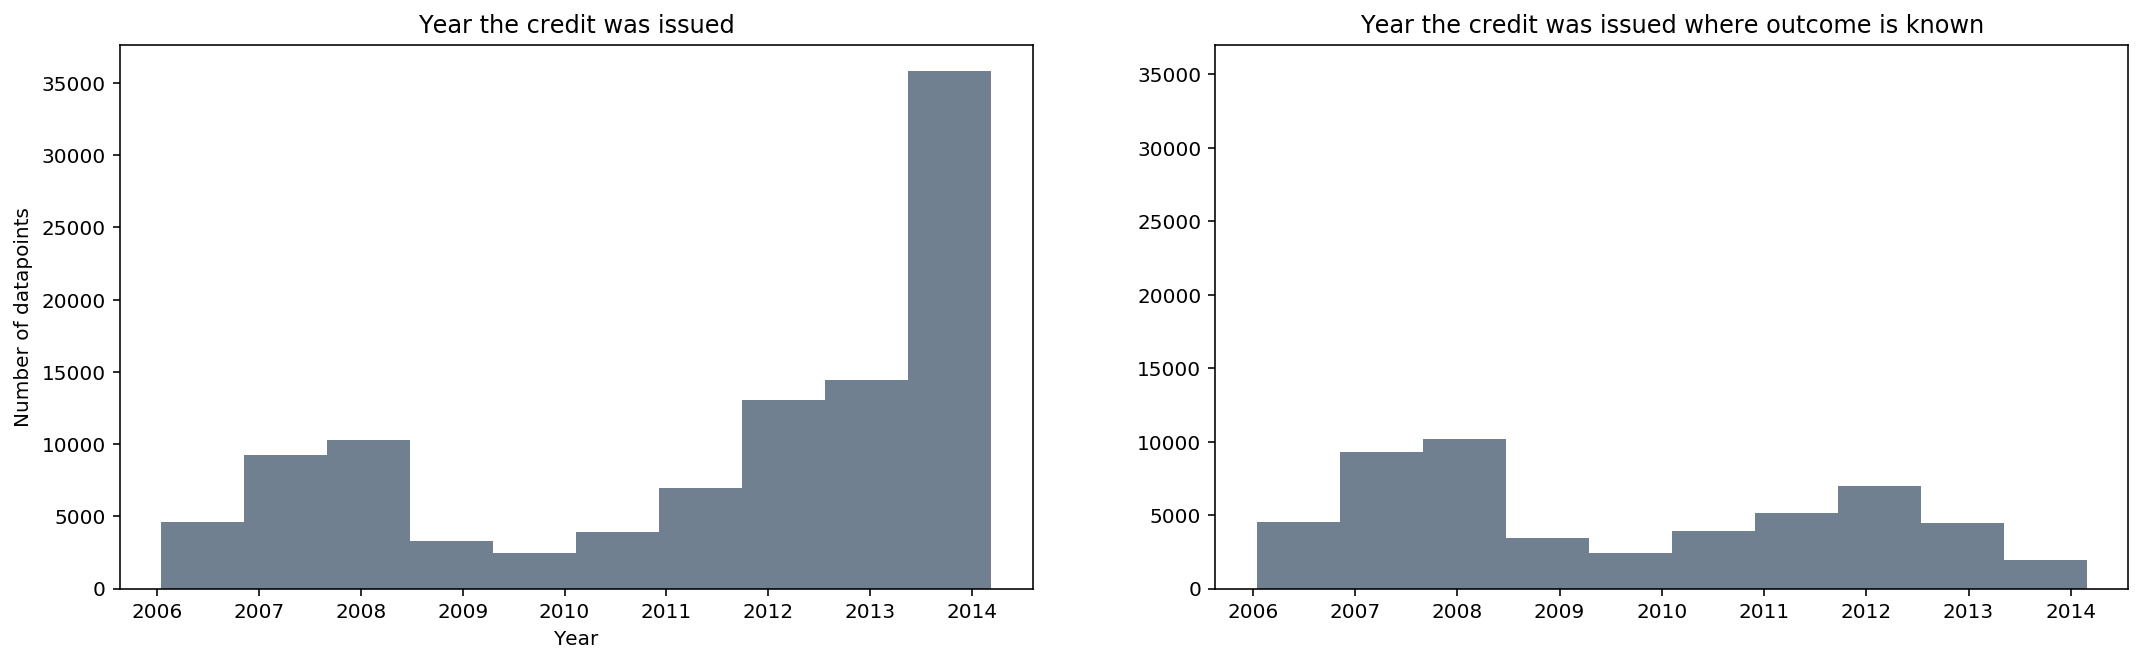

In [35]:
plt.figure(figsize = (18, 5))

plt.subplot(1, 2, 1)
plt.hist(df.date, color = base_color)
plt.title('Year the credit was issued')
plt.xlabel('Year')
plt.ylabel('Number of datapoints');

plt.subplot(1, 2, 2)
plt.hist(df.date[df['status'] != 'Current'], color = base_color)
plt.title('Year the credit was issued where outcome is known')
plt.ylim(0, 37000);

The left graph depicts the issued year for all loans, whereas the right graph only considers loans where the outcome is known (status is not current). Visible is that the dataset contains data for transactions from 2006 up to 2014. Most data were collected in the years 2013 and 2014. However, most of these datapoints cannod be considered in an investigation of outcomes as it is not known for most loans in those years.

#### What is the distribution of the monthly income?

In [36]:
df.monthly_income.describe()

count    104148.000000
mean       5395.961814
std        3037.264382
min           0.000000
25%        3333.000000
50%        4675.000000
75%        6750.000000
max       19958.000000
Name: monthly_income, dtype: float64

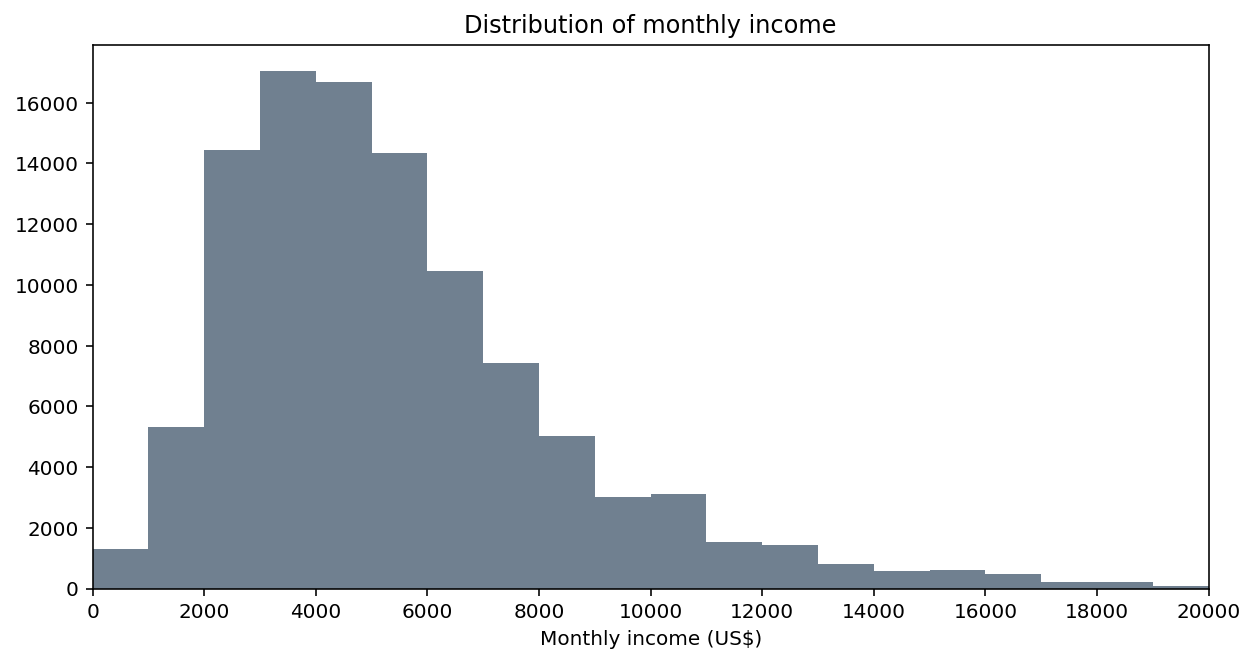

In [37]:
plt.figure(figsize = (10, 5))
plt.hist(df.monthly_income, bins = np.arange(0, 20500 + 1000, 1000), color = base_color)
plt.xticks(np.arange(0, 22000, 2000))
plt.xlim(0, 20001)
plt.title('Distribution of monthly income')
plt.xlabel('Monthly income (US$)');

Most individuals obtain a monthly income between 2000 and 7000 US$.

#### What is the distribution of the loan amount?

In [38]:
df.loan_amount.describe()

count    104148.000000
mean       8359.257749
std        6253.976927
min        1000.000000
25%        4000.000000
50%        6500.000000
75%       12000.000000
max       35000.000000
Name: loan_amount, dtype: float64

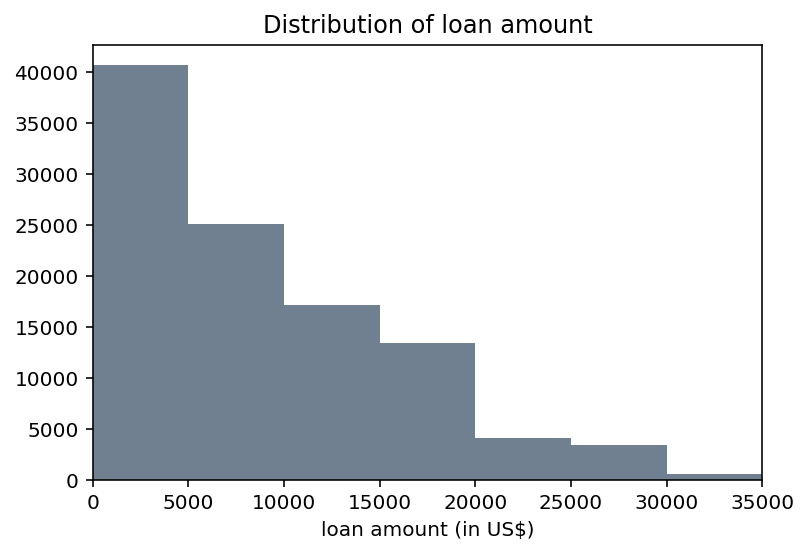

In [39]:
plt.hist(df.loan_amount, bins = np.arange(0, 35001, 5000), color = base_color)
plt.xlim(0, 35001)
plt.title('Distribution of loan amount')
plt.xlabel('loan amount (in US$)');

The plot of the loan amount is right skewed with most loans being less than 5,000$.

#### What are the propabilities for a loan to defaulted or be chargedoff?

In [40]:
outcome_df = df[df['status'].isin(['Completed', 'Chargedoff', 'Defaulted'])]

n = outcome_df.status.count()
n_max = outcome_df.status.value_counts().max()
p_max = n_max / n
ticks = np.arange(0, p_max + 0.1, 0.1)
labels = ['{:.1f}'.format(v) for v in ticks]
order = outcome_df.status.value_counts().index

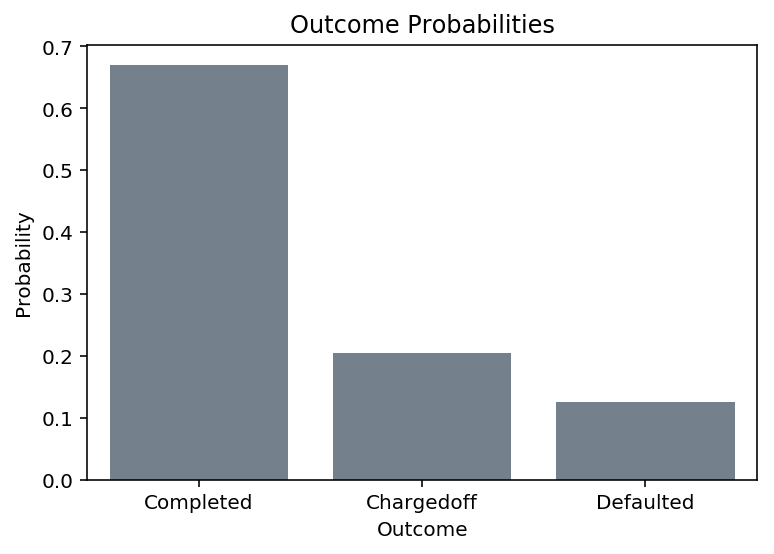

In [41]:
sns.countplot(outcome_df.status, color = base_color, order = order)
plt.yticks(ticks * n, labels)
plt.title('Outcome Probabilities')
plt.ylabel('Probability')
plt.xlabel('Outcome');

The probability of a loan to be payed back is 70%. 20% of all loans get charged off and 10% of all loans default. (Quick reminder: a loan is listed as defaulted if the borrower failed to make payments for an extended period of time. The status 'Defaulted' changes to 'Chargedoff' when there is no longer any reasonably expection for the loan to ever be payed back - the limit is set to 120 days defaulted in this case.)

#### Why do people take loans in the first place?

In [42]:
n = df.reason.count()
n_max = df.reason.value_counts().max()
p_max = n_max / n
ticks = np.arange(0, p_max + 0.05, 0.05)
labels = ['{:.2f}'.format(v) for v in ticks]
order = df.reason.value_counts().index

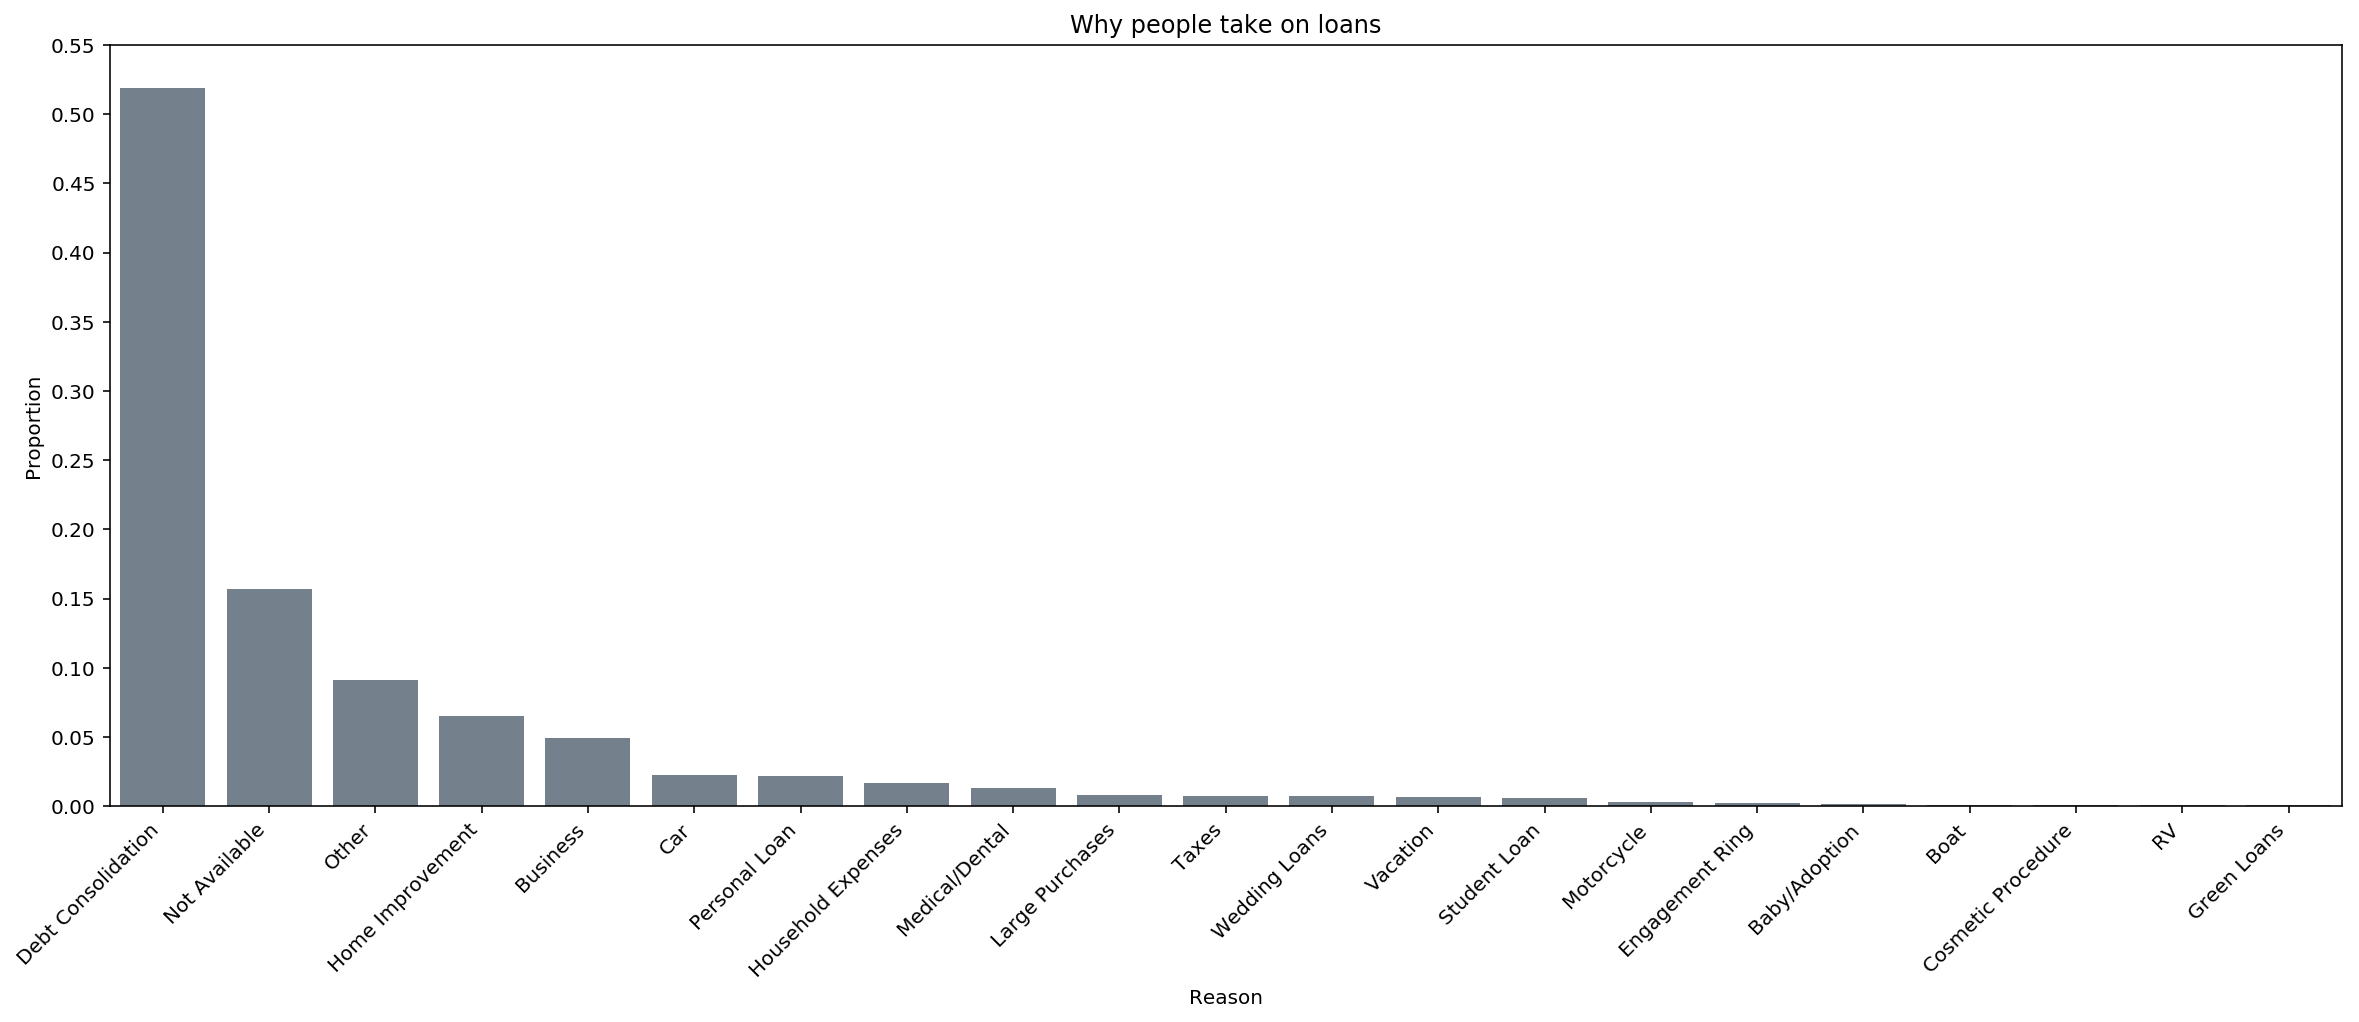

In [43]:
plt.figure(figsize = (20, 7))
sns.countplot(data = df, x = 'reason', order = order, color = base_color)
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(ticks * n, labels)
plt.ylabel('Proportion')
plt.xlabel('Reason')
plt.title('Why people take on loans');

The by far most common reason to take a loan is to pay back other loans, followed by home improvement, business reasons and to finance a car.

#### If debt consolidation is the most common reason to take a loan, then most borrowers should have already used a fair amount of their credit card limit?

In [44]:
# exclude NaN and any values higher than 1.1 to be able to plot the histogram
credit_df = df[(df['credit_utilization'].notnull()) & (df['credit_utilization'] < 1.1)]

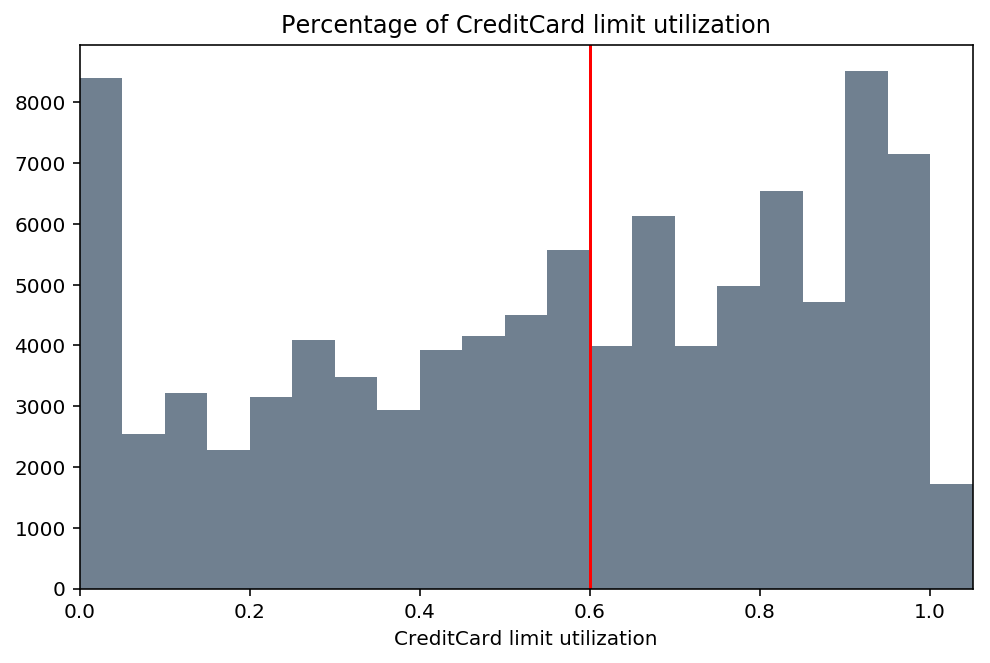

In [45]:
plt.figure(figsize = (8, 5))
plt.hist(credit_df.credit_utilization, bins = np.arange(0, 1.1, 0.05), color = base_color)
plt.xlim(0, 1.05)
plt.axvline(credit_df.credit_utilization.median(), color = 'r')
plt.title('Percentage of CreditCard limit utilization')
plt.xlabel('CreditCard limit utilization');

And indeed, the above histogram underlines this issue. The red line marks the median Borrowers CreditCard limit utilization. Despite the decent amount of people who did not make use of any of their CreditCard debt, 50 percent of all borrowers have already used more than 60% of their CreditCard limit. 

#### What is the total debt-to-income ratio of borrowers?

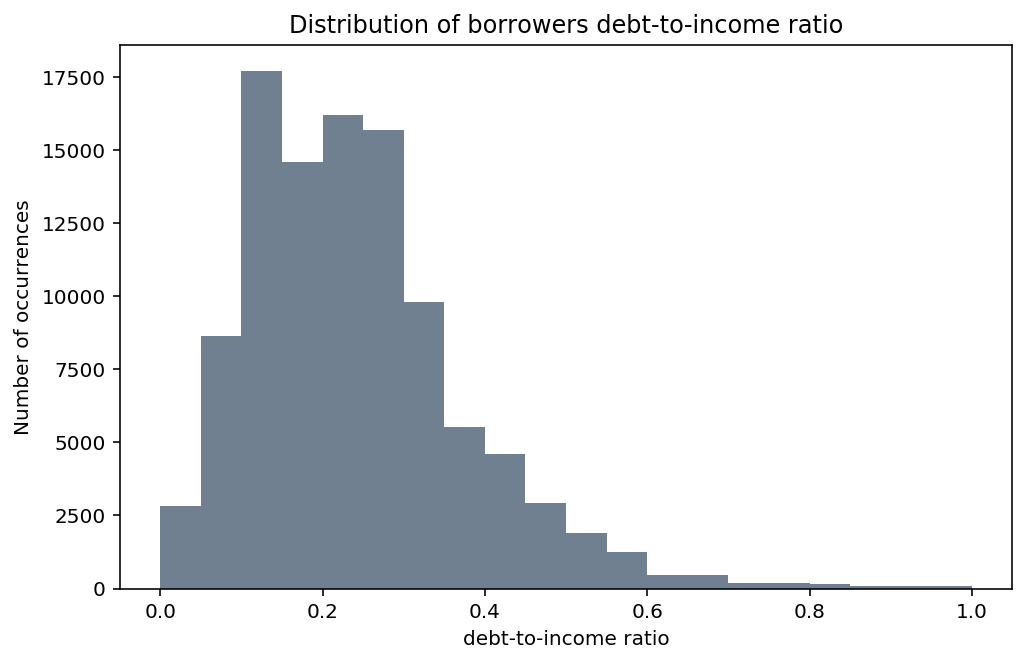

In [46]:
debt = df[(df['debt_ratio'].notnull()) & (df['debt_ratio'] < 1.01)]

plt.figure(figsize = (8, 5))
plt.hist(debt.debt_ratio, bins = np.arange(0, 1 + 0.05, 0.05), color = base_color)
plt.title('Distribution of borrowers debt-to-income ratio')
plt.xlabel('debt-to-income ratio')
plt.ylabel('Number of occurrences');

Most borrowers already have a debt to income ratio between 10 and 30 percent.

### Bivariate Exploration

#### How do the borrowers APR and the lenders yield compare?

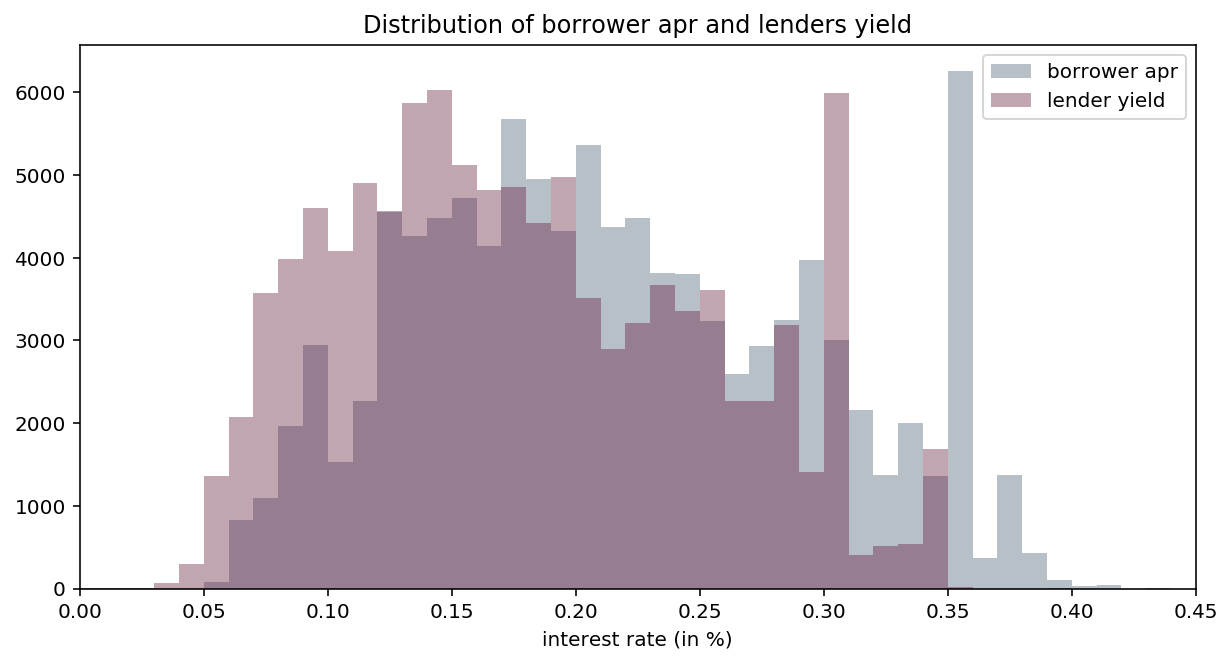

In [47]:
plt.figure(figsize = (10, 5))
plt.hist(df.borrower_apr, bins = np.arange(0, 0.5, 0.01), color = '#708090', alpha = 0.5)
plt.hist(df.lender_yield, bins = np.arange(0, 0.5, 0.01), color = '#651e3e', alpha = 0.4)
plt.legend(['borrower apr', 'lender yield'])
plt.xlim(0, 0.45)
plt.title('Distribution of borrower apr and lenders yield')
plt.xlabel('interest rate (in %)');

The distribution of the lenders yield is basically a left skewed borrowers apr curve. This makes sense with the difference between both variables being prospers share in the deal. Interestingly, theres a major elevation at the 0.35 mark for the borrower apr and the 0.30 mark for the lender yield.

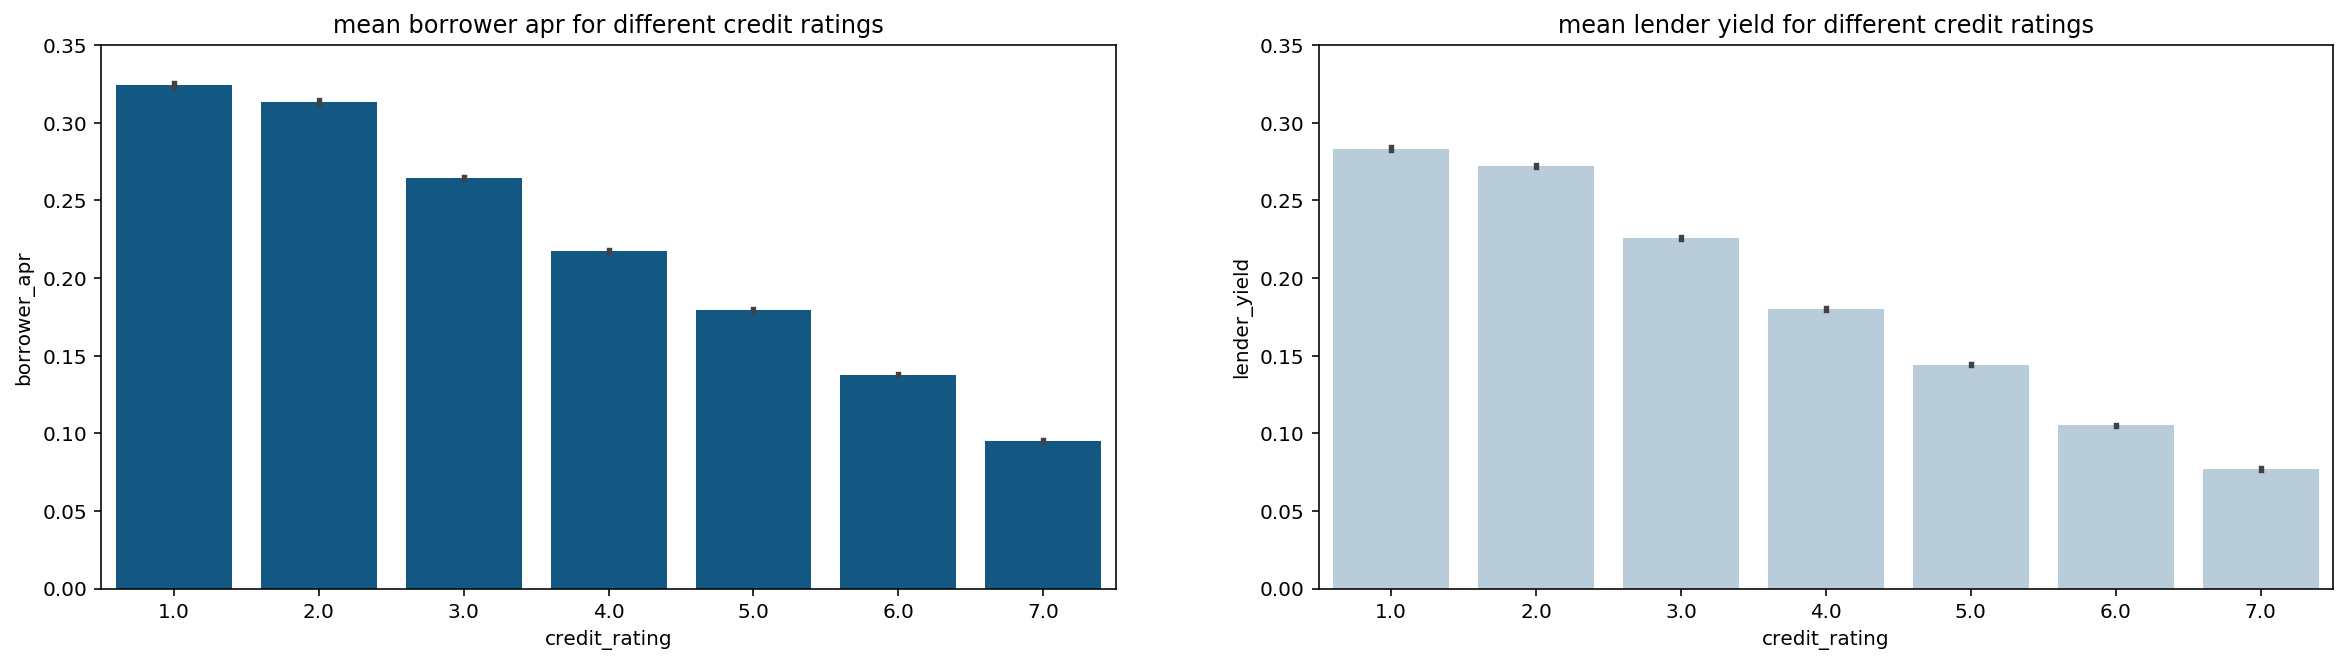

In [48]:
data = df[df['credit_rating'] != 0] # exclude credit rating of 0 (NaN)

plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sns.barplot(data = data, x = 'credit_rating', y = 'borrower_apr', color = '#005b96')
plt.ylim([0, 0.35])
plt.title('mean borrower apr for different credit ratings')

plt.subplot(1, 2, 2)
sns.barplot(data = data, x = 'credit_rating', y = 'lender_yield', color = '#b3cde0')
plt.ylim([0, 0.35])
plt.title('mean lender yield for different credit ratings');

The mean borrower rate decreases with a better credit rating. The same goes for the lender yield.

#### What about the mean loan amount?

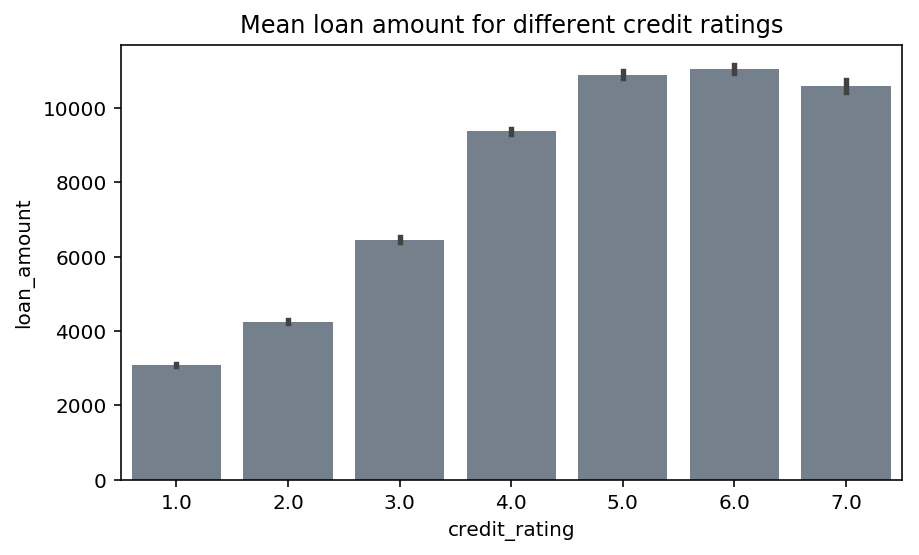

In [49]:
plt.figure(figsize = (7, 4))
sns.barplot(data = data, x = 'credit_rating', y = 'loan_amount', color = base_color)
plt.title('Mean loan amount for different credit ratings');

Interesting. Individuals with a lower credit rating tend to on average take lower loans. This effect however stops at a credit rating of 6 where the average loan amount does not increase any further.

#### What are the differences for different outcomes?

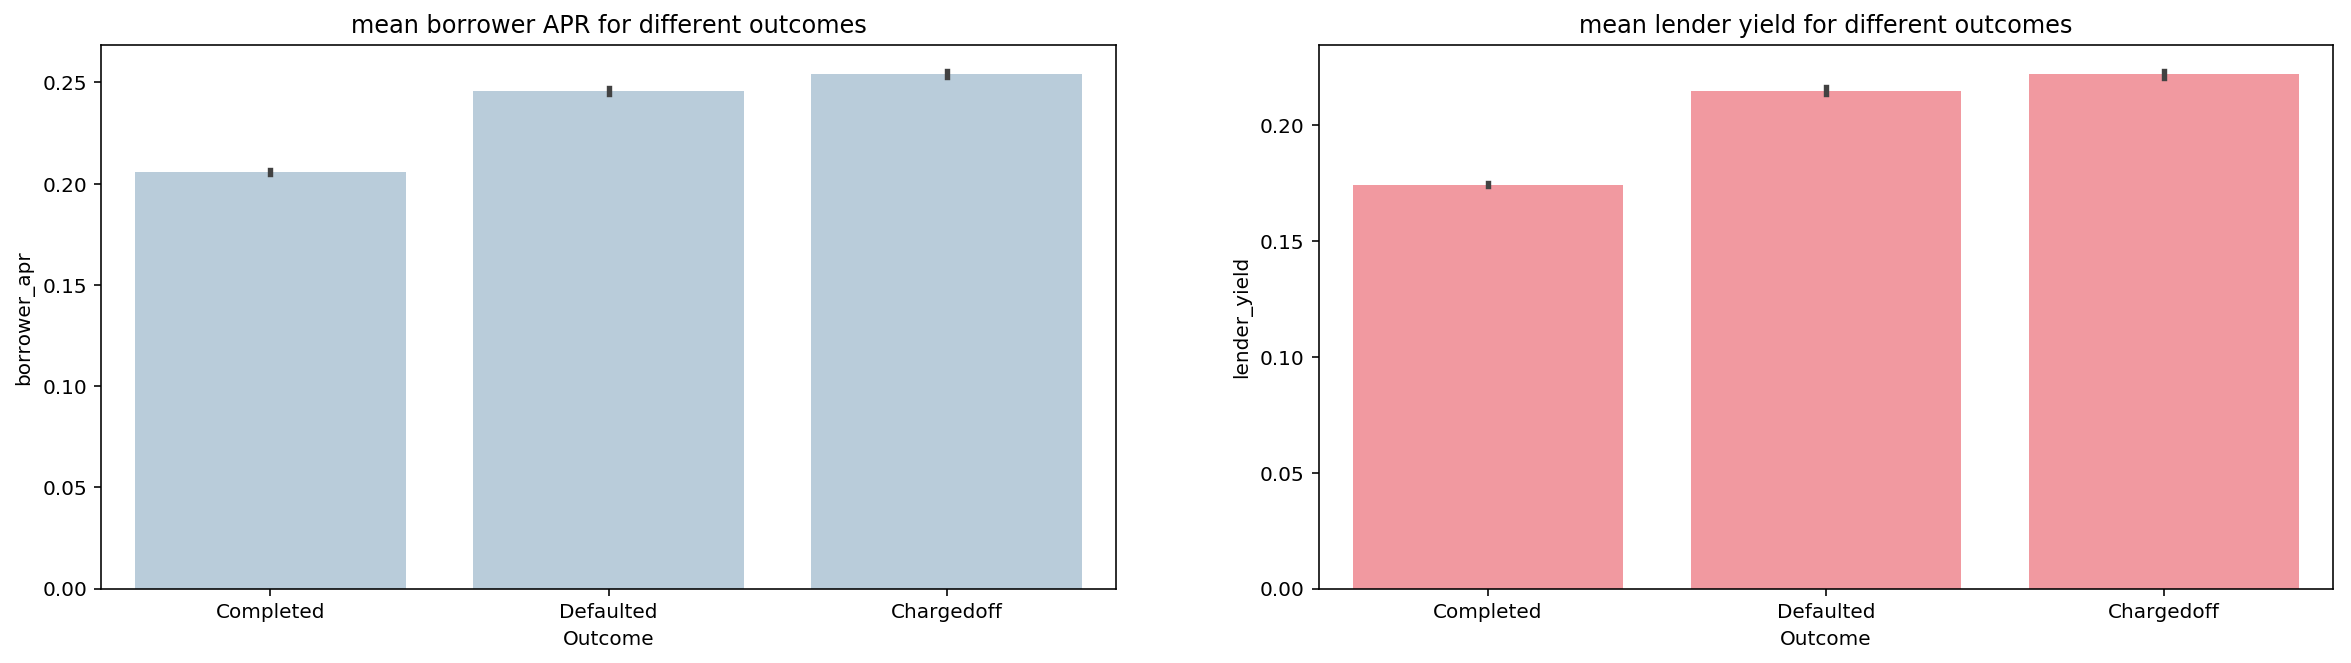

In [50]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sns.barplot(data = outcome_df, x = 'status', y = 'borrower_apr', color = '#b3cde0')
plt.title('mean borrower APR for different outcomes')
plt.xlabel('Outcome');

plt.subplot(1, 2, 2)
sns.barplot(data = outcome_df, x = 'status', y = 'lender_yield', color = '#ff8b94')
plt.title('mean lender yield for different outcomes')
plt.xlabel('Outcome');

In [51]:
outcome_df.groupby('status')['borrower_apr'].median()

status
Chargedoff    0.25517
Completed     0.19088
Defaulted     0.24753
Name: borrower_apr, dtype: float64

In [52]:
outcome_df.groupby('status')['lender_yield'].median()

status
Chargedoff    0.2250
Completed     0.1600
Defaulted     0.2184
Name: lender_yield, dtype: float64

Completed Loans had on average a lower interest rate for both borrower and lender. Defaulted or charged off loans had on average a higher interest rate. The median borrower apr of a chargedoff loan is 25.5%. The median borrower apr of a completed loan is 19.1%.

#### How do the outcome probabilities compare for different credit ratings?

In [53]:
# Query the outcome df to only include the columns status and credit_rating
query = outcome_df[['status', 'credit_rating']]

# Exclude credit rating 0 (equivalent to NaN)
query = query[query['credit_rating'] != 0]

# groupby credit rating and status to get get a df with the count for each status
groupby_credit_rating = query.groupby(['credit_rating', 'status']).size().reset_index()
groupby_credit_rating.head()

,credit_rating,status,0
0,1.0,Chargedoff,2154
1,1.0,Completed,3202
2,1.0,Defaulted,1302
3,2.0,Chargedoff,1841
4,2.0,Completed,3736


In [54]:
# create lists which contain the values for each category for each rating 
completed = list(groupby_credit_rating.query('"Completed" in status')[0])
defaulted = list(groupby_credit_rating.query('"Defaulted" in status')[0])
chargedoff = list(groupby_credit_rating.query('"Chargedoff" in status')[0])

In [55]:
# construct a new df used for the stacked bar graph
raw_data = {'Completed': completed, 'Defaulted': defaulted, 'Chargedoff': chargedoff}
outcome_stacked = pd.DataFrame(raw_data)

In [56]:
# convert the values from absolute to percentage
totals = [i + j + k for i, j, k in zip(outcome_stacked['Completed'], outcome_stacked['Defaulted'],\
                                       outcome_stacked['Chargedoff'])]
Completed = [i / j * 100 for i, j in zip(outcome_stacked['Completed'], totals)]
Defaulted = [i / j * 100 for i, j in zip(outcome_stacked['Defaulted'], totals)]
Chargedoff = [i / j * 100 for i, j in zip(outcome_stacked['Chargedoff'], totals)]

r = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']

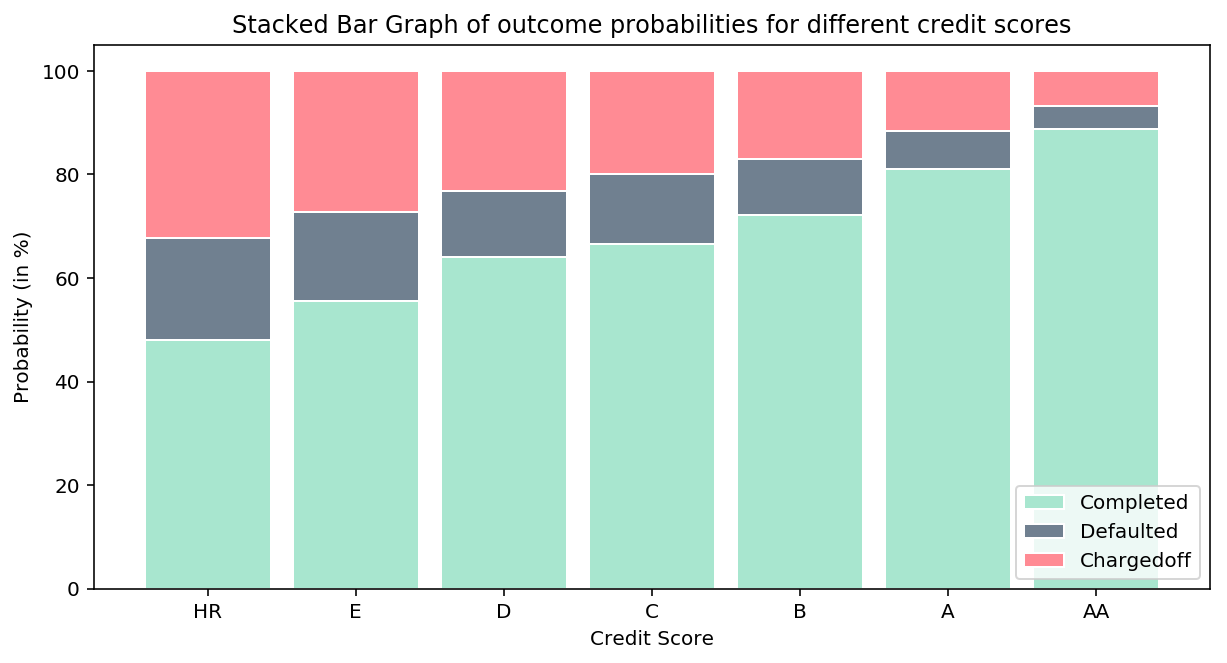

In [57]:
# plot the stacked bar graph
width = 0.85

plt.figure(figsize = (10, 5))

plt.bar(r, Completed, color = '#a8e6cf', edgecolor = 'white', width = width, label = 'Completed')
plt.bar(r, Defaulted, bottom = Completed, color = base_color, edgecolor = 'white', width = width, label = 'Defaulted')
plt.bar(r, Chargedoff, bottom = [i + j for i, j in zip(Completed, Defaulted)], color = '#ff8b94',\
        edgecolor = 'white', width = width, label = 'Chargedoff')

plt.title('Stacked Bar Graph of outcome probabilities for different credit scores')
plt.legend(loc = 'lower right')
plt.xlabel('Credit Score')
plt.ylabel('Probability (in %)');

My favorite plot of this project. It depicts the probability of a credit outcome depending on the credit score. If a borrower received a credit score of 1, then the probability of the loan to be completed is only 50 percent. On the other hand, a credit score of 7 is associated with a payback rate of more than 80%.

Resource: [Stacked Bar Graph](https://python-graph-gallery.com/13-percent-stacked-barplot/)

#### For loans which default or get charged off, what were the reasons specified by the borrower? (absolute amount)

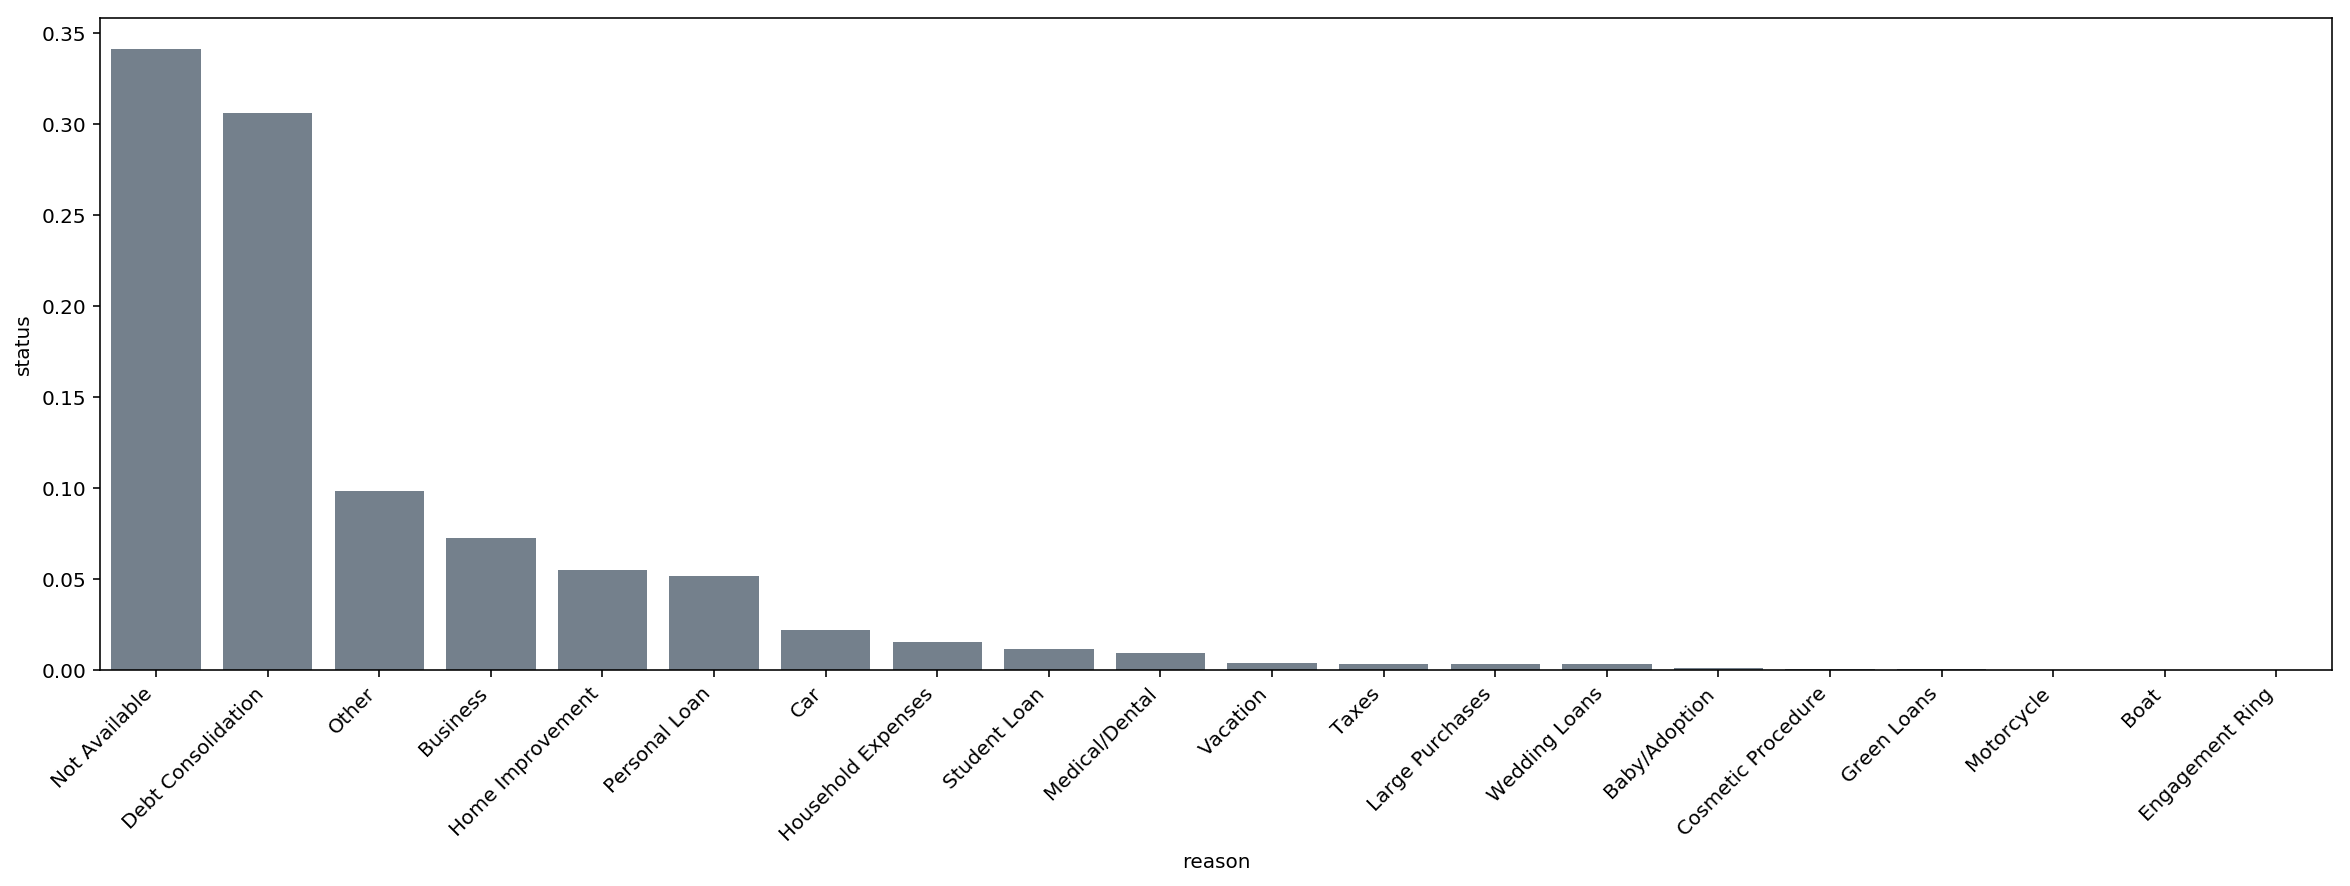

In [58]:
chargedoff = outcome_df[outcome_df['status'] == 'Chargedoff']
chargedoff = chargedoff.groupby('reason')['status'].count().reset_index().sort_values('status', ascending = False)

n = chargedoff.status.sum()
n_max = chargedoff.status.head(1)
p_max = n_max / n
ticks = np.arange(0, p_max + 0.05, 0.05)
labels = ['{:.2f}'.format(v) for v in ticks]

plt.figure(figsize = (20, 6))
sns.barplot(chargedoff.reason, chargedoff.status, color = base_color)
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(ticks * n, labels)
plt.title('');

#### Probability of a loan do default for different reasons borrower took loan (amount relative to reason total)

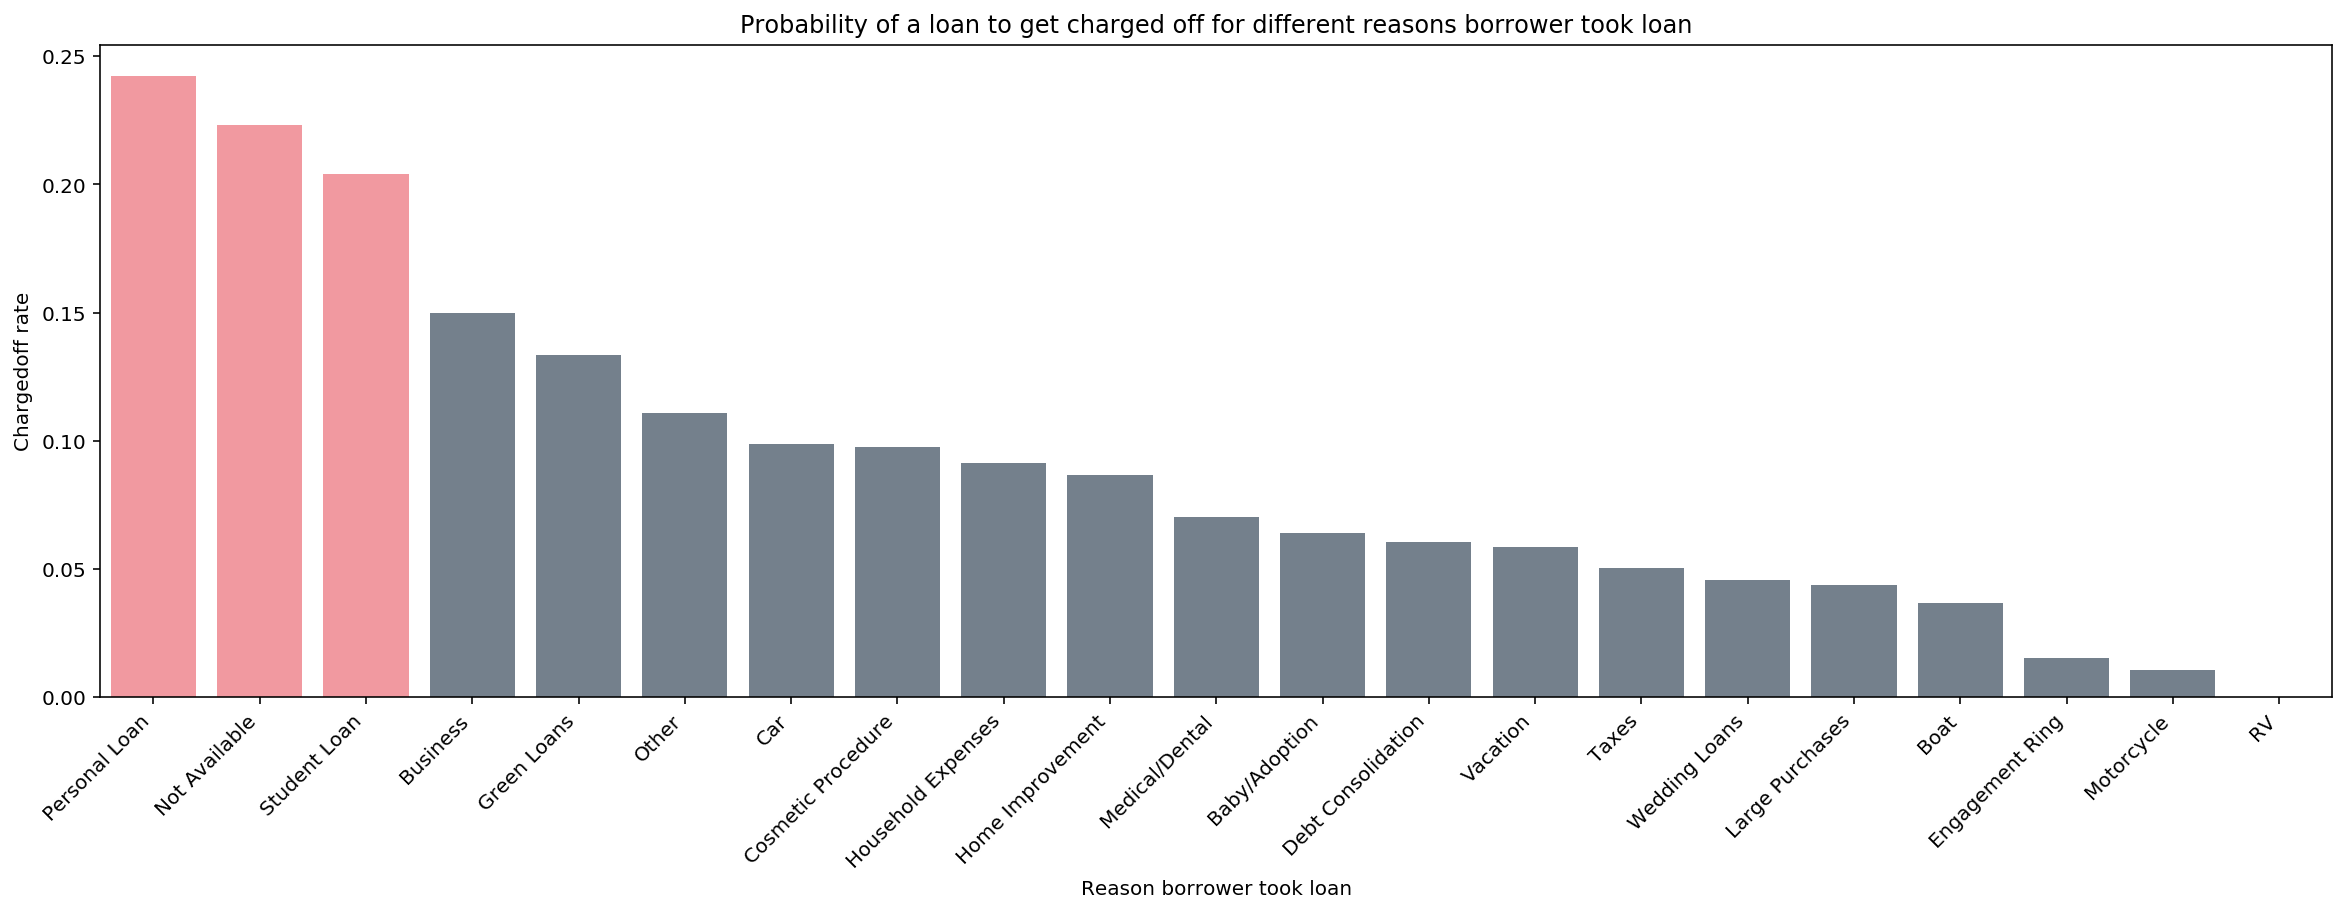

In [59]:
# get a df which only contains the status value chargedoff
chargedoff = outcome_df[outcome_df['status'] == 'Chargedoff']
chargedoff = chargedoff.groupby('reason')['status'].count().reset_index().sort_values('status', ascending = False)

# create a dictionary which contains as keys the reason and as values the chargedoff count
dict1 = dict(zip(chargedoff['reason'], chargedoff['status']))

# create a second dictionary which contains as key the reason and as value the total count
dict2 = dict(df.reason.value_counts())

# feature engineer a third dictionary which contains the chargedoff rate for each reason dict1 / dict2 
dict3 = {key: dict1.get(key, 0) / dict2.get(key, 0) for key in set(dict1) | set(dict2)}

# create a dataframe from the dictionary to be able to sort values in descending order
reason_chargedoff = pd.DataFrame.from_dict(dict3, orient = 'index').reset_index()
reason_chargedoff.columns = ['reason', 'chargedoff_rate']
reason_chargedoff = reason_chargedoff.sort_values('chargedoff_rate', ascending = False)

# plot
clrs = ['#ff8b94' if (x in list(reason_chargedoff.reason.head(3))) else base_color for x in reason_chargedoff.reason]

plt.figure(figsize = (20, 6))
sns.barplot(data = reason_chargedoff, x = 'reason', y = 'chargedoff_rate', palette = clrs)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Chargedoff rate')
plt.xlabel('Reason borrower took loan')
plt.title('Probability of a loan to get charged off for different reasons borrower took loan');

The highest Chargedoff rate is for Personal Loans, Not Available and Student Loans. 

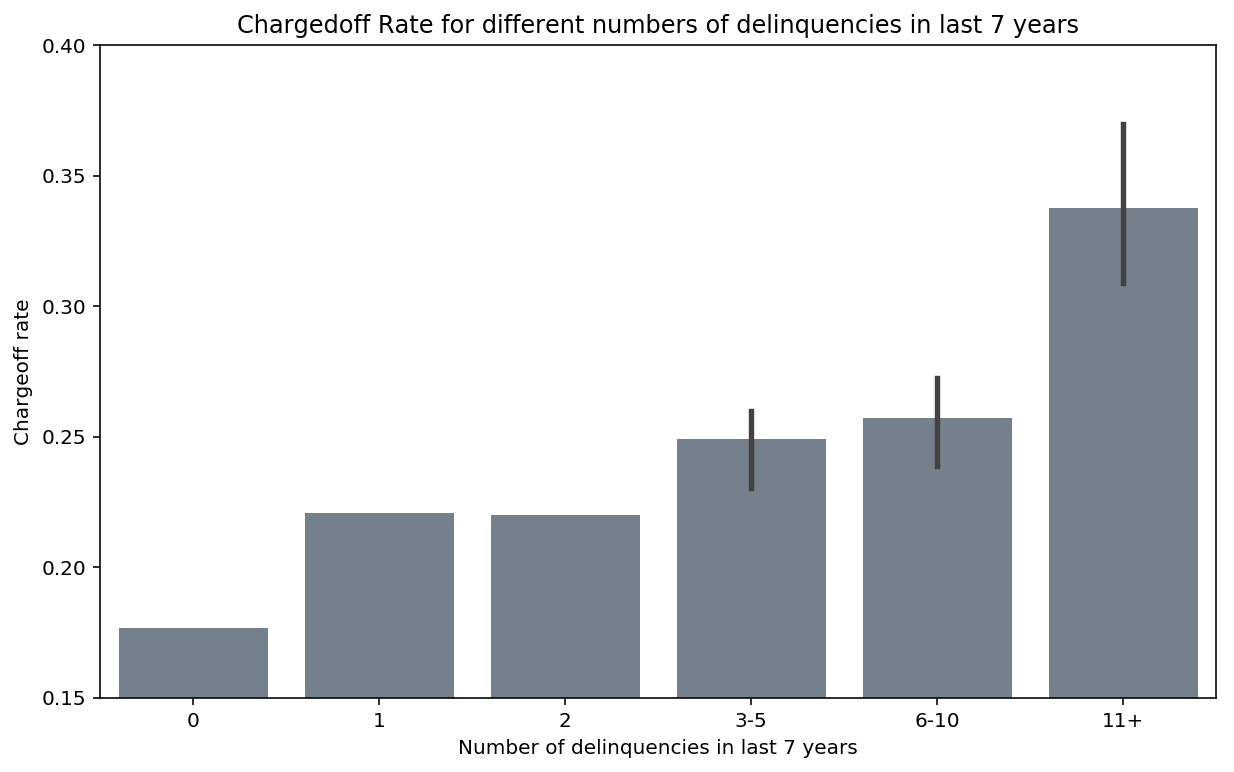

In [60]:
delinquencies_chargedoff = outcome_df[outcome_df['status'] == 'Chargedoff']
delinquencies_chargedoff = delinquencies_chargedoff.groupby('number_delinquencies')['status'].size().reset_index()

# -1 first bin because left side is exclusive and I want to catch 0 separate from 1
bins = [-1, 0, 1, 2, 5, 10, 100]
delinquencies_chargedoff['bins'] = pd.cut(delinquencies_chargedoff['number_delinquencies'], bins)

delinquencies_chargedoff.columns = ['number_delinquencies', 'number_chargedoff', 'bins']

delinquencies_total = outcome_df.groupby('number_delinquencies')['status'].size().reset_index()
delinquencies_total.columns = ['number_delinquencies', 'total_number_loans']

delinquencies = pd.merge(delinquencies_chargedoff, delinquencies_total, on = 'number_delinquencies') 
delinquencies['chargedoff_rate'] = delinquencies['number_chargedoff'] / delinquencies['total_number_loans']

plt.figure(figsize = (10, 6))
sns.barplot(data = delinquencies, x = 'bins', y = 'chargedoff_rate', color = base_color)
plt.xticks(np.arange(0, 6), [0, 1, 2, '3-5', '6-10', '11+'])
plt.yticks(np.arange(0, 0.45, 0.05))
plt.ylim(0.15, 0.4)
plt.ylabel('Chargeoff rate')
plt.xlabel('Number of delinquencies in last 7 years')
plt.title('Chargedoff Rate for different numbers of delinquencies in last 7 years');

In [61]:
occupation_chargedoff = outcome_df[outcome_df['status'] == 'Chargedoff']
occupation_chargedoff = occupation_chargedoff.groupby('occupation')['status'].size().reset_index()

In [62]:
occupation_total = outcome_df.groupby('occupation')['status'].size().reset_index()
occupation_chargedoff = pd.merge(occupation_chargedoff, occupation_total, on = 'occupation')
occupation_chargedoff['chargedoff_rate'] = occupation_chargedoff['status_x'] / occupation_chargedoff['status_y']
occupation_chargedoff = occupation_chargedoff.sort_values('chargedoff_rate', ascending = False)

In [63]:
occupation_chargedoff.head()

,occupation,status_x,status_y,chargedoff_rate
23,Homemaker,12,35,0.342857
55,Student - Community College,7,21,0.333333
30,Nurse (LPN),60,180,0.333333
50,Student - College Freshman,9,27,0.333333
21,Food Service,164,496,0.330645


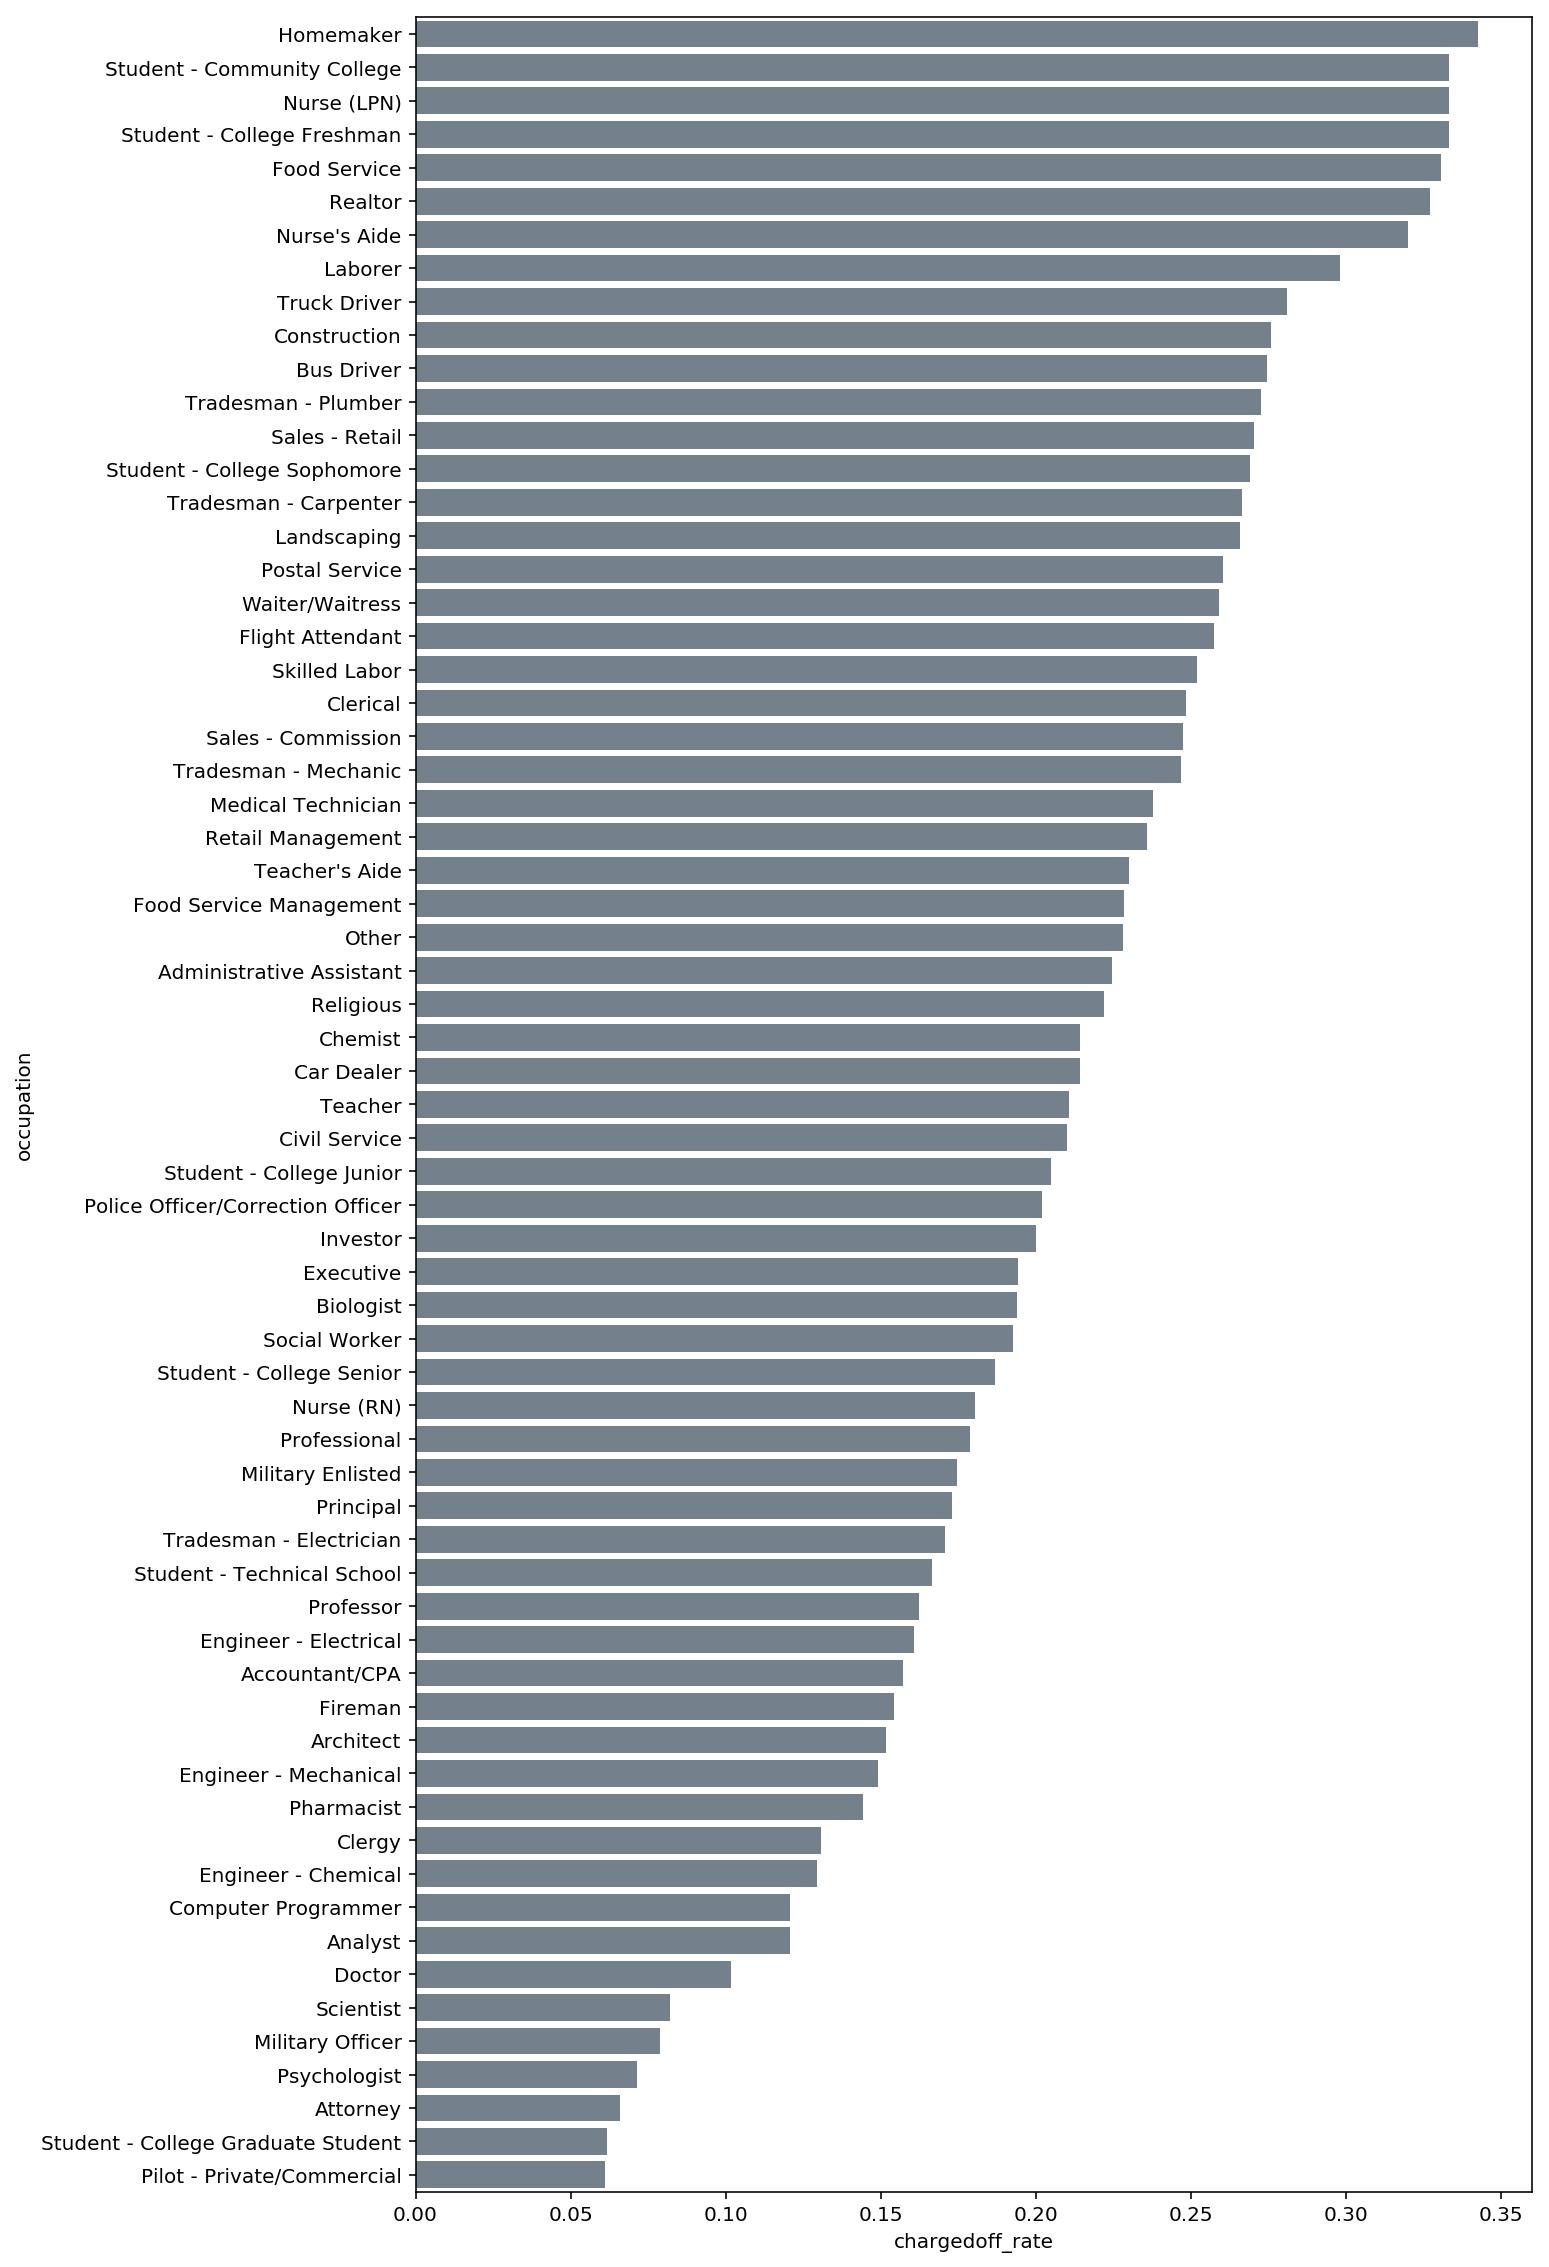

In [64]:
plt.figure(figsize = (10, 20))
sns.barplot(data = occupation_chargedoff, y = 'occupation', x = 'chargedoff_rate', color = base_color);

#### Are homeowners offered a lower APR?

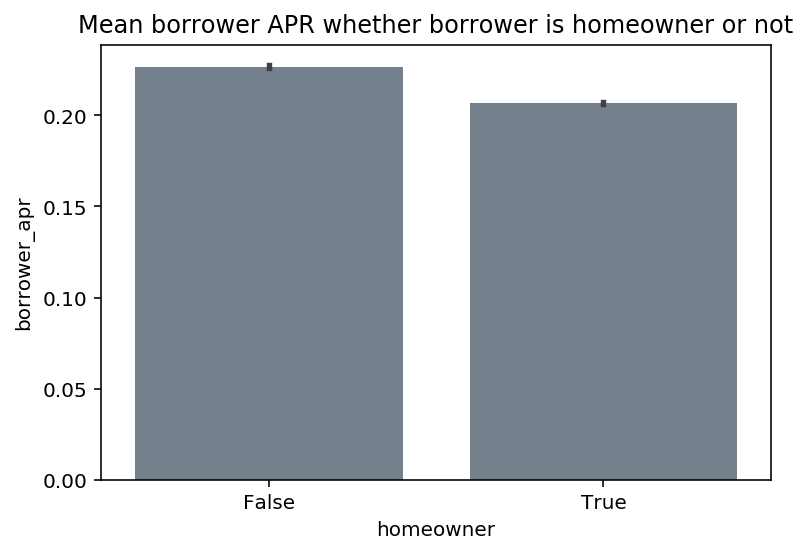

In [65]:
sns.barplot(data = df, x = 'homeowner', y = 'borrower_apr', color = base_color)
plt.title('Mean borrower APR whether borrower is homeowner or not');

A borrower who is already a homeowner gets on average a lower APR compared to a borrower not already owns a home.

#### Are there differences for the borrowers APR depending on the state he lives in?

Get a df which is grouped by state and sorted by the mean borrower APR in descending order:

In [66]:
homestate_df = df.groupby('homestate').mean().reset_index().sort_values('borrower_apr', ascending = False)
homestate_df.homestate.head().values

array(['AL', 'AR', 'SD', 'MS', 'NV'], dtype=object)

Color encode to highlight the 5 states with the on average highest borrower APR's:

In [67]:
clrs = ['#ff8b94' if (x in ['AL', 'AR', 'SD', 'MS', 'NV']) else '#b3cde0' for x in homestate_df.homestate]

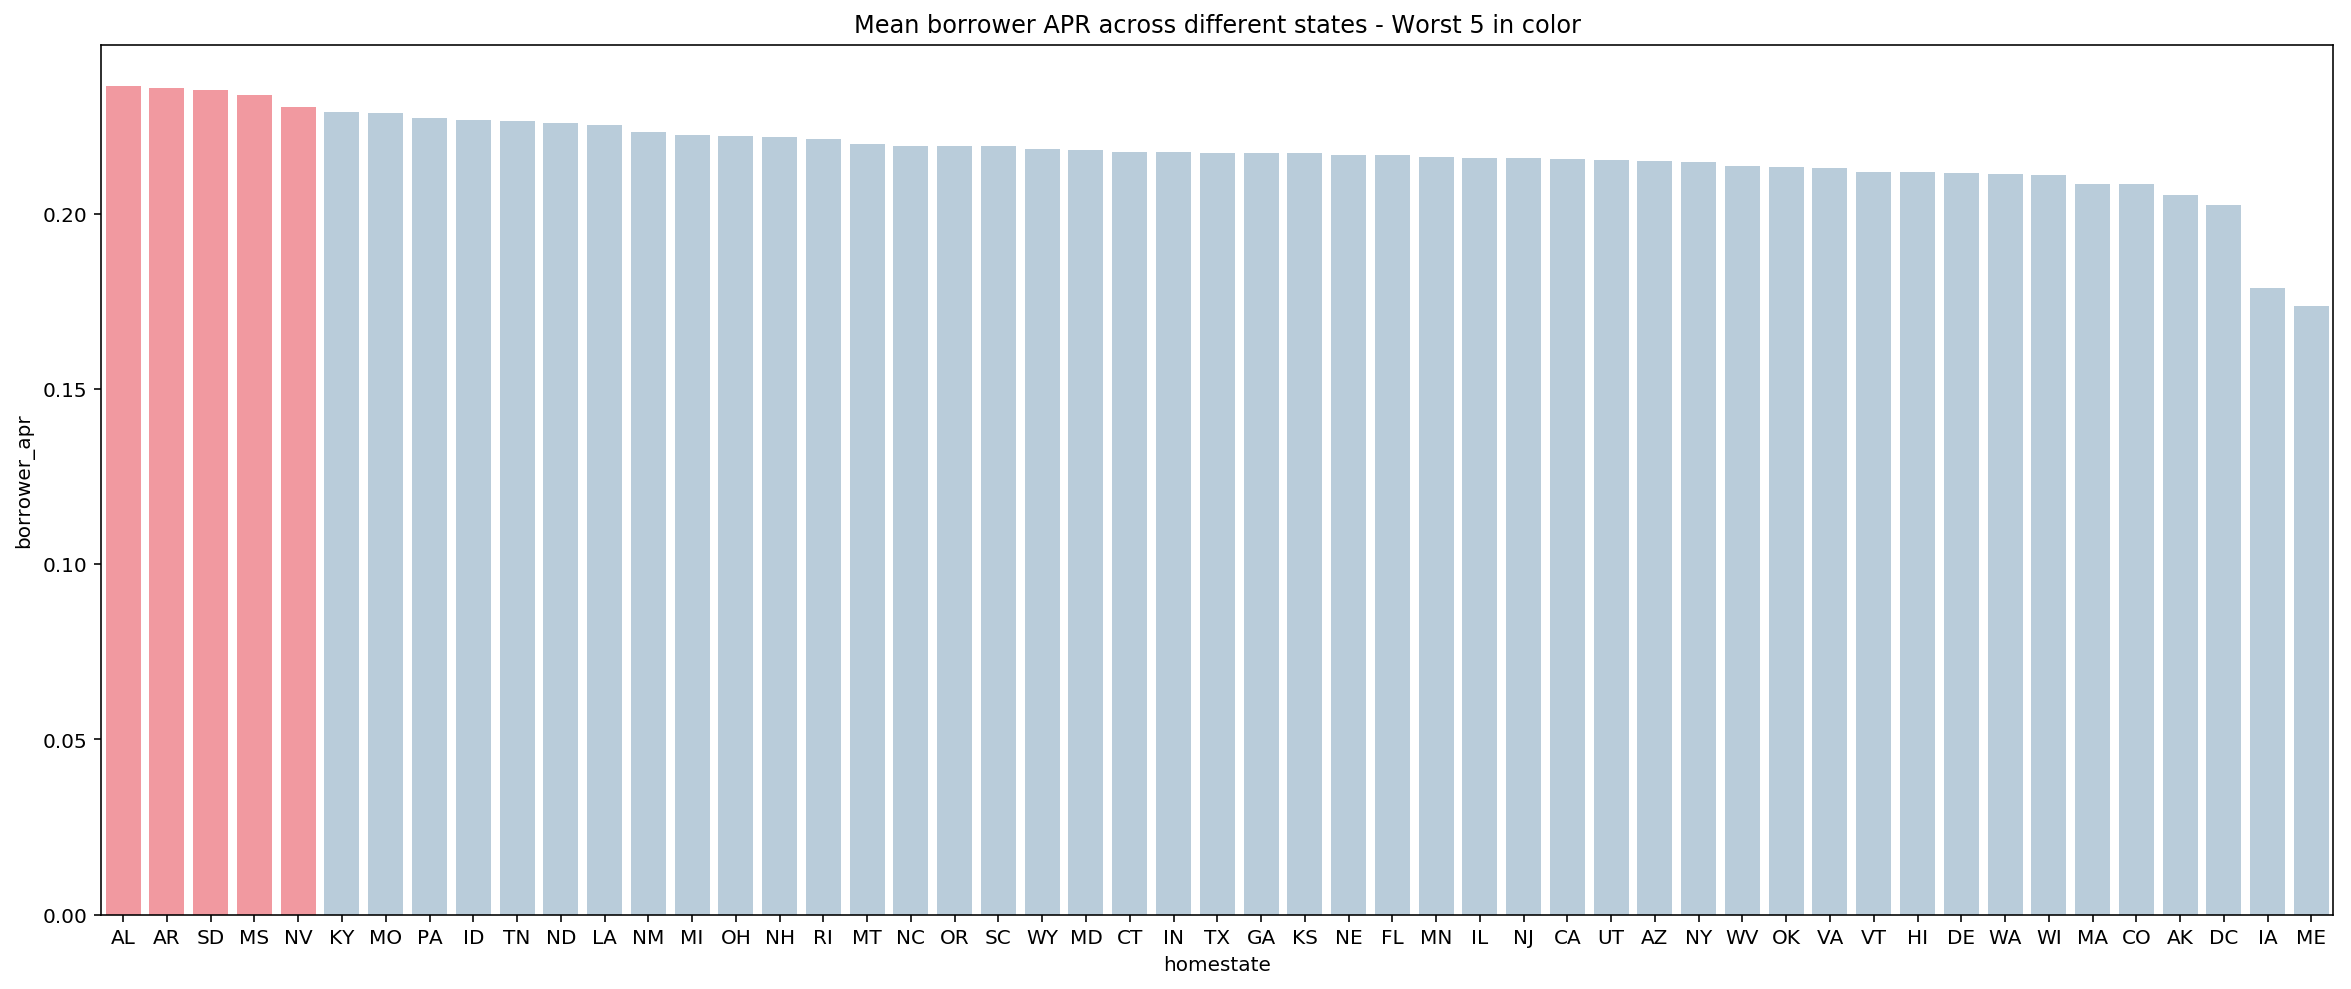

In [68]:
plt.figure(figsize = (20, 8))
sns.barplot(data = df, y = 'borrower_apr', x = 'homestate', order = homestate_df['homestate'], palette = clrs, ci = None)
plt.title('Mean borrower APR across different states - Worst 5 in color');

**What about the chargeoff rates for different states?**

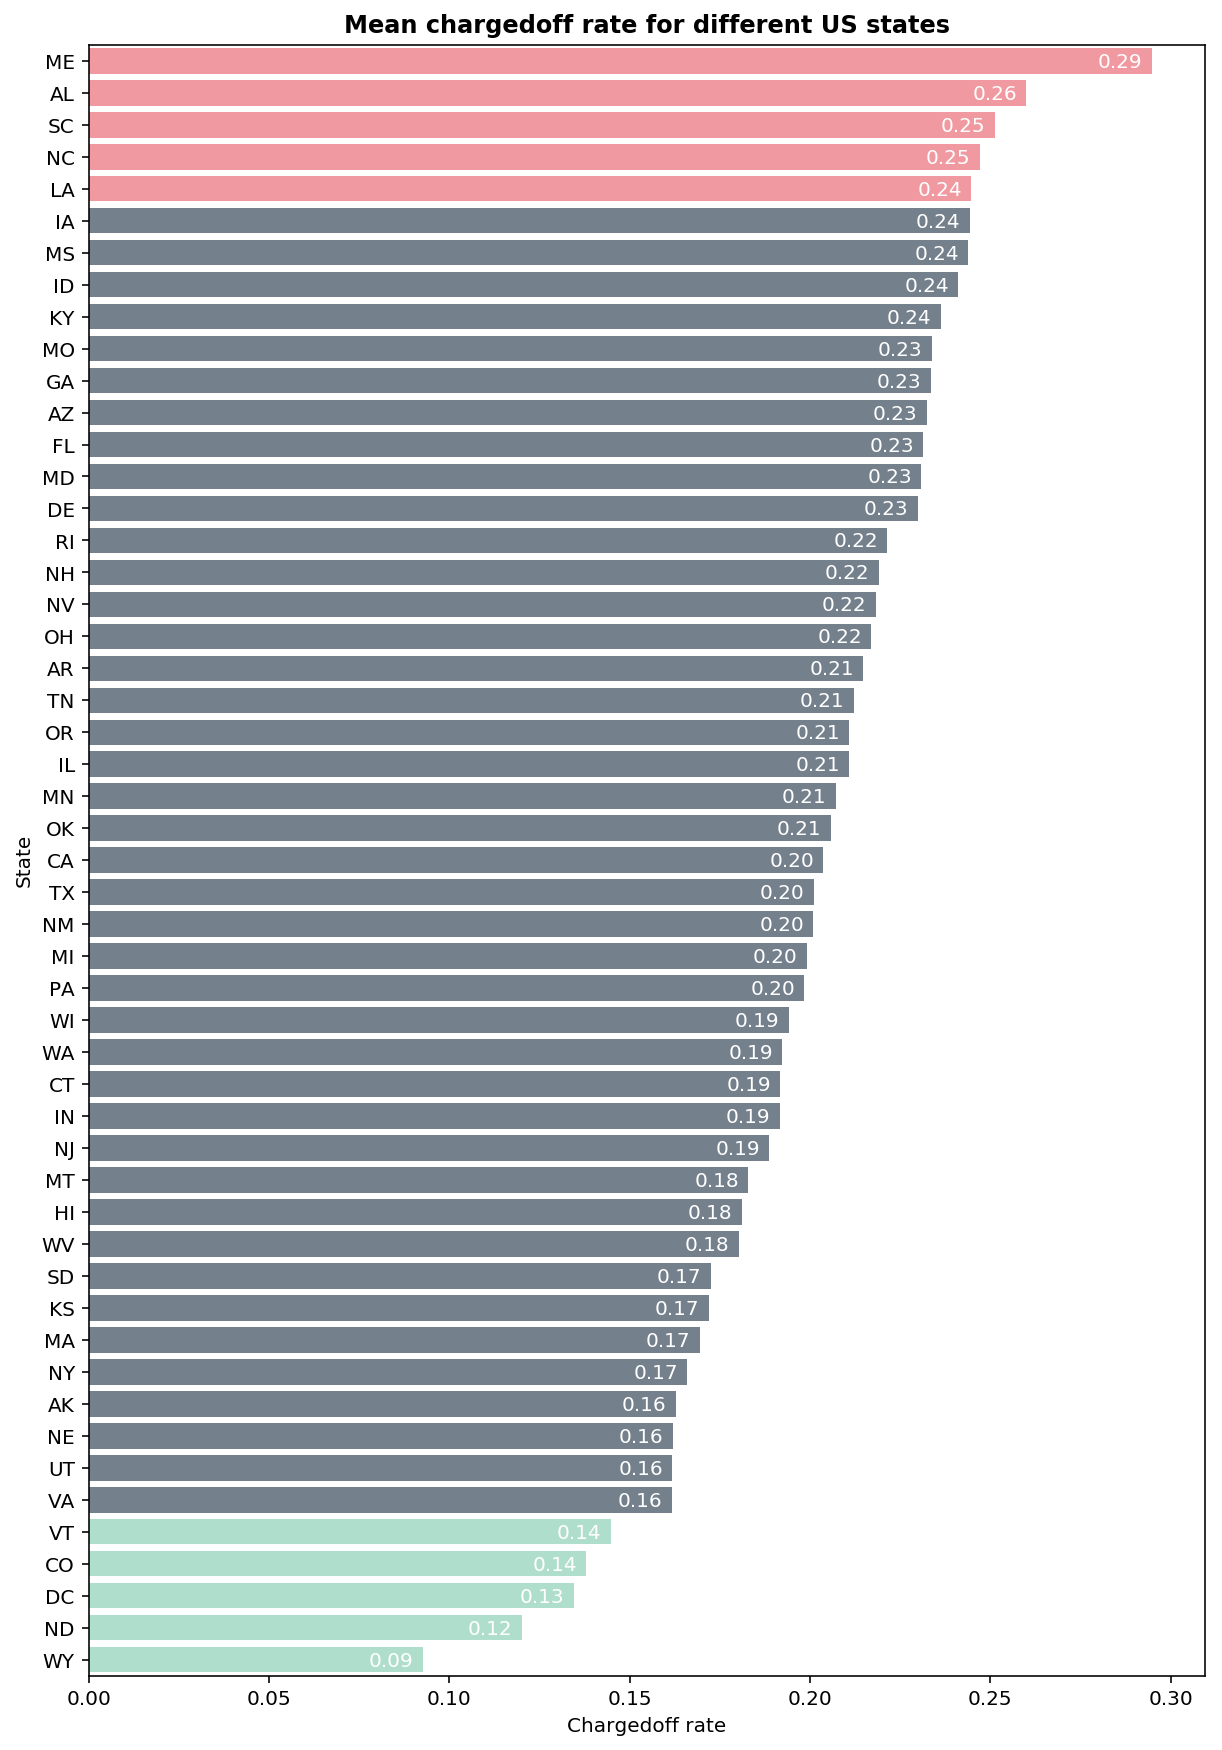

In [79]:
homestate_chargedoff = outcome_df[outcome_df['status'] == 'Chargedoff']
homestate_chargedoff = homestate_chargedoff.groupby('homestate')['status'].size().reset_index()
homestate_total = outcome_df.groupby('homestate')['status'].size().reset_index()

homestate_df = pd.merge(homestate_chargedoff, homestate_total, on = 'homestate')
homestate_df['chargedoff_rate'] = homestate_df.status_x / homestate_df.status_y
homestate_df = homestate_df.sort_values('chargedoff_rate', ascending = False)

clrs = np.repeat(base_color, 51)
clrs[[0, 1, 2, 3, 4]] = '#ff8b94'
clrs[[46, 47, 48, 49, 50]] = '#a8e6cf'

plt.figure(figsize = (10, 15))
sns.barplot(data = homestate_df, x = 'chargedoff_rate', y = 'homestate', palette = clrs)
plt.title('Mean chargedoff rate for different US states', weight = 'bold')
plt.ylabel('State')
plt.xlabel('Chargedoff rate');

xlocs = np.arange(0, 51)
for i, v in enumerate(list(homestate_df.chargedoff_rate)):
    plt.text(v - 0.015, xlocs[i] + 0.2, "{:.2f}".format(v), color = 'white')

#### Are there differences for the borrowers APR regarding the borrowers occupation?

In [69]:
occupation_df = df.groupby('occupation').mean().reset_index().sort_values('borrower_apr', ascending = False)
occupation_list = list(occupation_df.occupation.tail())

In [70]:
clrs = ['#a8e6cf' if (x in occupation_list) else '#b3cde0' for x in occupation_df.occupation]

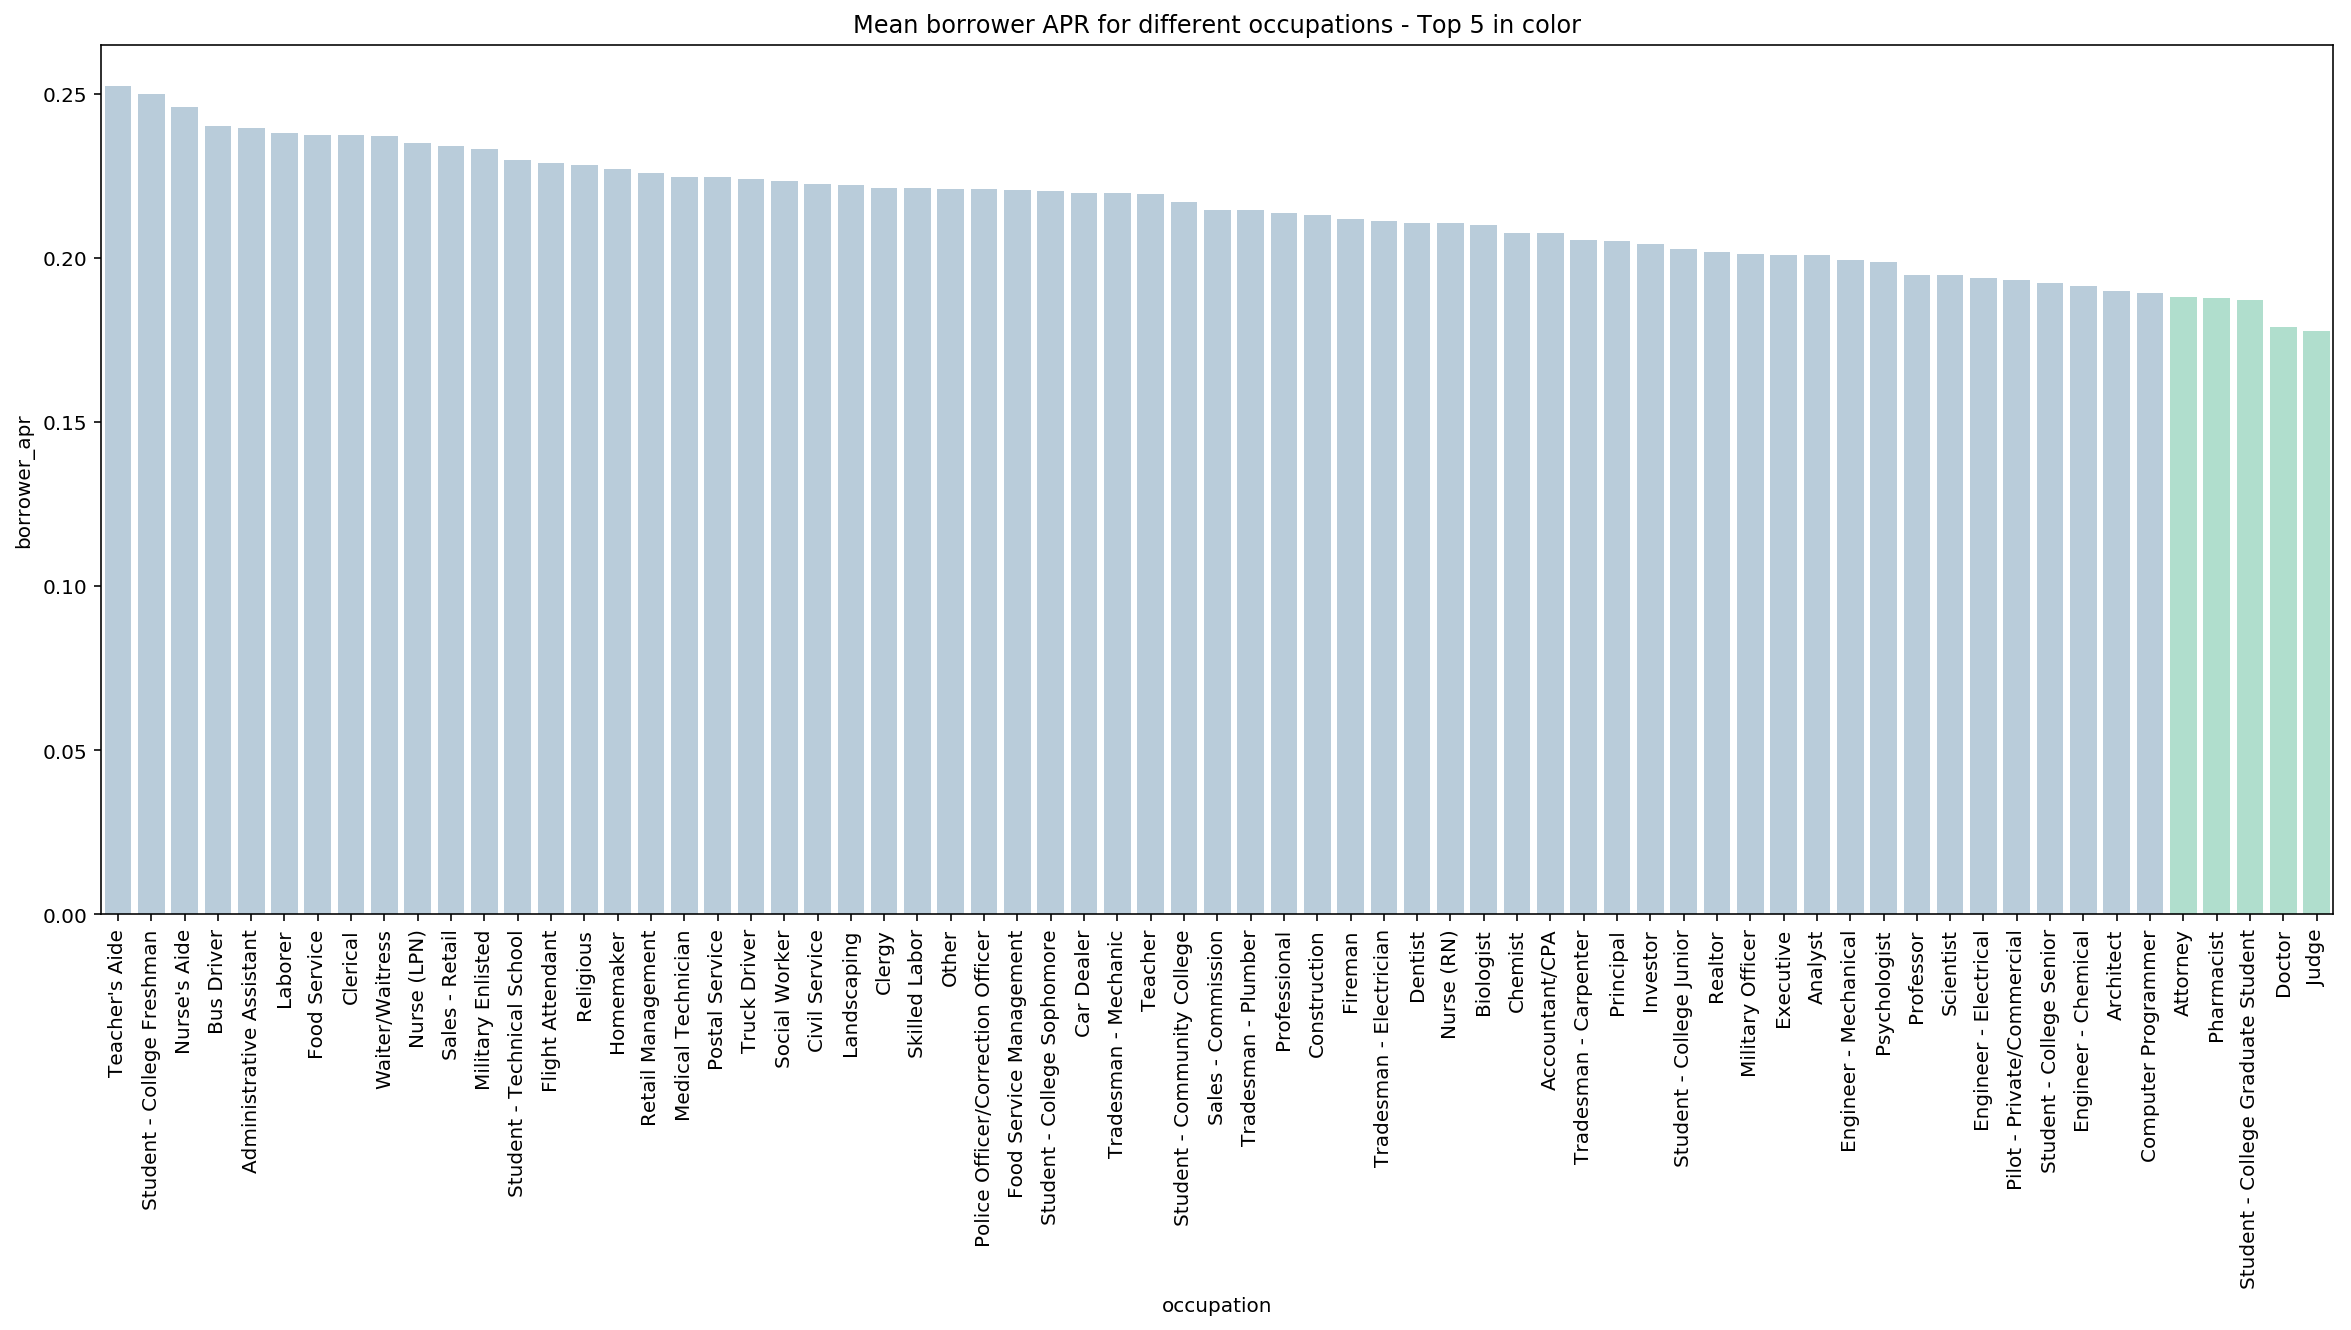

In [71]:
plt.figure(figsize = (20, 8))
sns.barplot(data = df, x = 'occupation', y = 'borrower_apr', order = occupation_df['occupation'], palette = clrs, ci = None)
plt.title('Mean borrower APR for different occupations - Top 5 in color')
plt.xticks(rotation = 90);

Teachers aides, college freshmans and nurse's aides are charged the highest aprs. College graduate students, doctors and judges are offered the best conditions.

### Multivariate Exploration

#### Development of interest rates over time

In [72]:
groupby_year = df.groupby(df.date.dt.year).mean().reset_index()

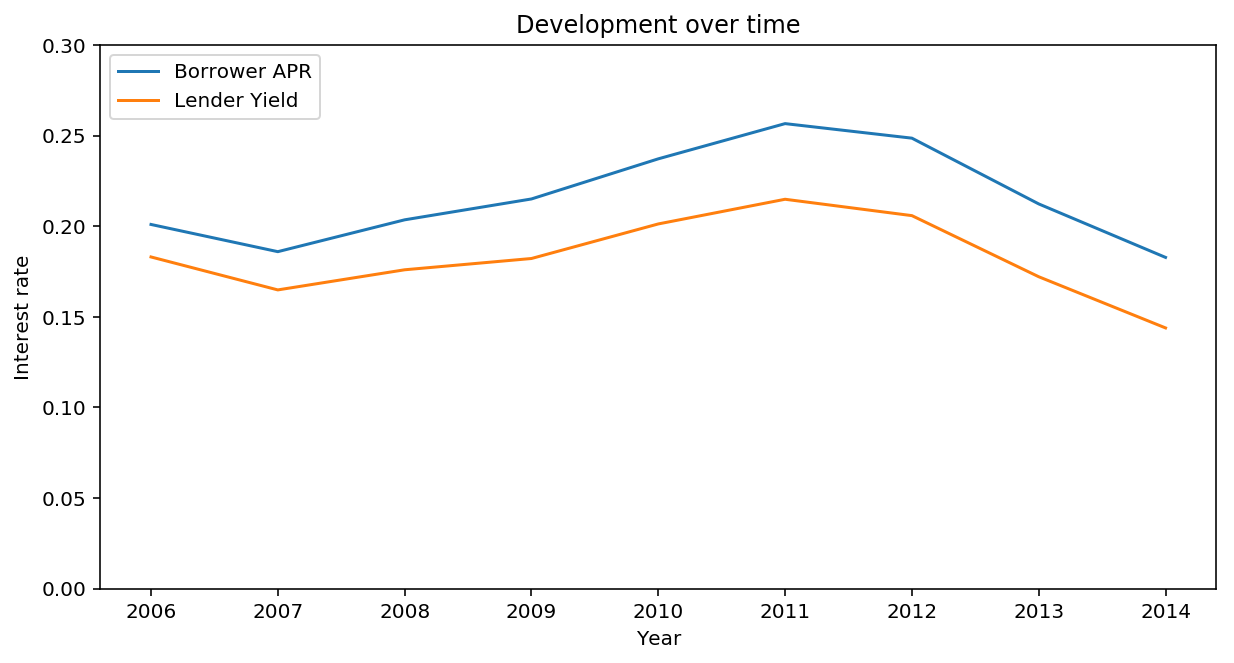

In [73]:
plt.figure(figsize = (10, 5))
plt.plot(groupby_year.date, groupby_year.borrower_apr)
plt.plot(groupby_year.date, groupby_year.lender_yield)
plt.ylim([0, 0.3])
plt.title('Development over time')
plt.xlabel('Year')
plt.ylabel('Interest rate')
plt.legend(['Borrower APR', 'Lender Yield'], loc = 'upper left');

#### Other time series exploration (not multivariate)

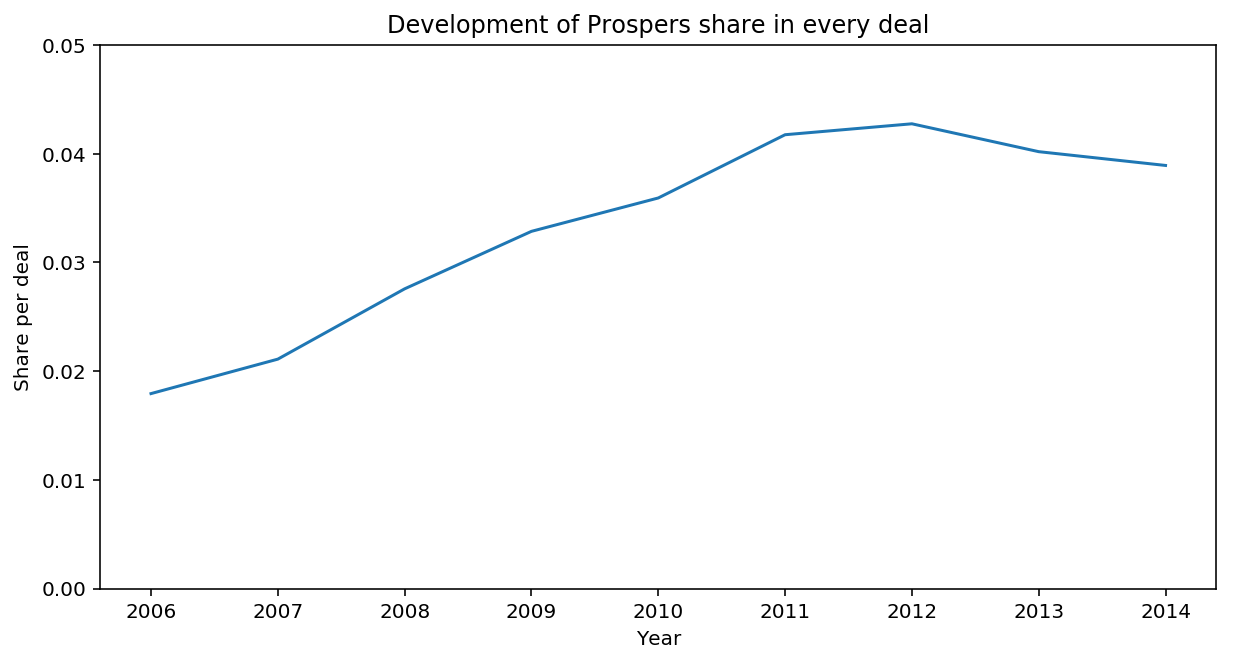

In [74]:
plt.figure(figsize = (10, 5))

plt.plot(groupby_year.date, groupby_year.bank_yield)
plt.ylim([0, 0.05])
plt.title('Development of Prospers share in every deal')
plt.xlabel('Year')
plt.ylabel('Share per deal');

Prospers share in every deal nearly doubled from 2% in 2006 to 4% in 2014 indicating a greater gap between the borrowers apr and the lenders yield.

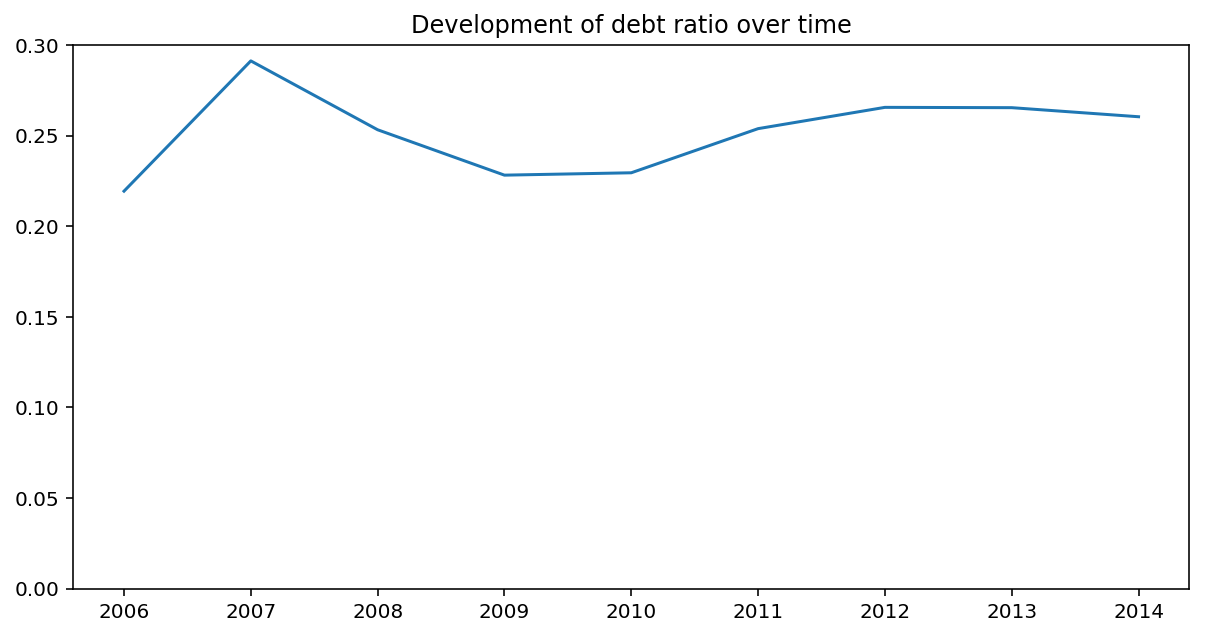

In [75]:
plt.figure(figsize = (10, 5))
plt.plot(groupby_year.date, groupby_year.debt_ratio)
plt.ylim(0, 0.3)
plt.title('Development of debt ratio over time');

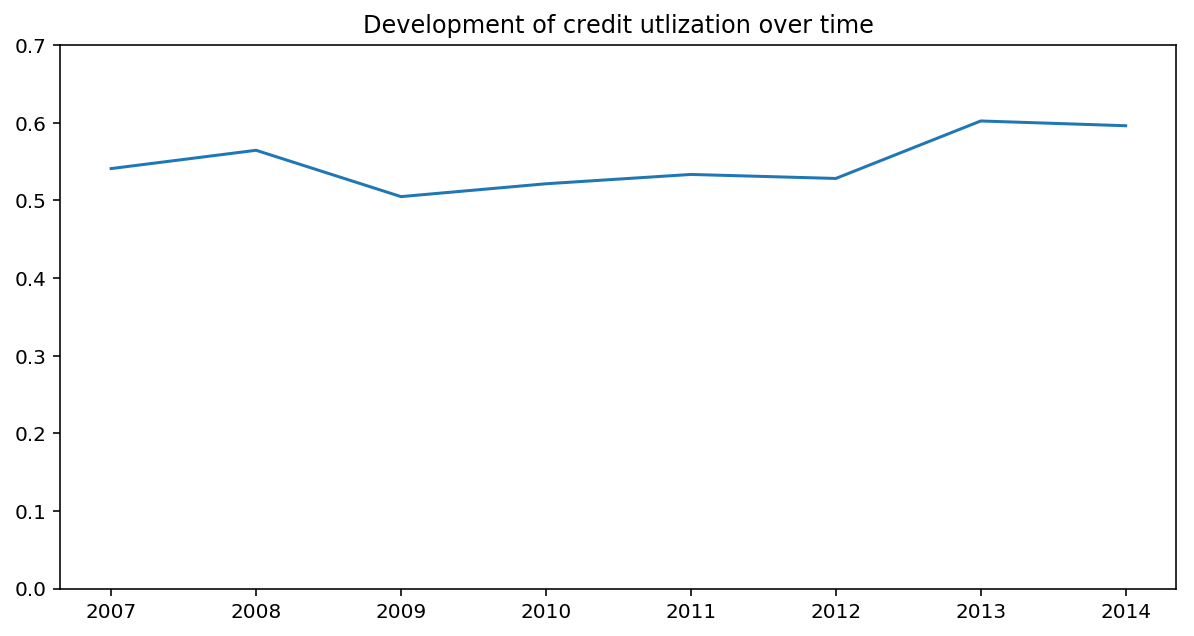

In [76]:
plt.figure(figsize = (10, 5))
plt.plot(groupby_year.date, groupby_year.credit_utilization)
plt.ylim(0, 0.7)
plt.title('Development of credit utlization over time');